# AutoInland Vehicle Insurance Claim Challenge 

This notebook looks into using various python-based machine learning and data science libraries in an attempt to develop a predictive machine learning model that determines if a customer will submit a vehicle insurance claim within next three months from their first transaction.

## What we'll end up with
Since we already have a dataset, we'll approach the problem with the following machine learning modelling framework.

To work through these topics, we'll use pandas, Matplotlib and NumPy for data anaylsis, as well as, Scikit-Learn for machine learning and modelling tasks.

We'll work through each step and by the end of the notebook, we'll have a handful of models, all which can predict whether or not a customer will claim insurance within the first three months using F1 score as the evaluation metric.

## 1. Problem Definition

This notebook is an insurance claim classification machine learning project with an imbalanced class.In this case, the problem we will be exploring is binary classification (a sample can only be one of two things).

This is because we are going to be using a number of different features (pieces of information) to predict if a customer will submit a vehicle insurance claim within next three months from their first transaction.

## 2. Data

The dataset came from Zindi in a formatted way [Zindi](https://zindi.africa/competitions/autoinland-vehicle-insurance-claim-challenge/data)

The data describes ~12,000 policies sold by AutoInland for car insurance. Information on the car type, make, customer age and start of policy are in the data.

## 3. Evaluation

The evaluation metric is something to define at the start of a project.

Since machine learning is very experimental:

           If we can get a very high F1 score at predicting whether or not a customer will submit a vehicle insurance claim within next three months from their first transaction during the proof of concept, we'll pursue this project.
           
## 4. Features

Features are different parts of the data. We're going to visualize the relationships between the different features of the data and how it can lead to stroke.

One of the most common ways to understand the features is to look at the **data dictionary**. For this project, the data dictionary is in the **Variable Definitions** csv file.

In [2]:
# Data Manipulation
import numpy as np
import pandas as pd
import scipy

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

# Feature Selection and Encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Machine Learning
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

# Random search
from sklearn.model_selection import RandomizedSearchCV 

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedShuffleSplit

# Manage warnings
import warnings
warnings.filterwarnings('ignore')

#For Datetime
import datetime as dt

from tqdm.notebook import tqdm_notebook

# Plot the figure inline
%matplotlib inline 

### 2. Load the data

In [3]:
# Load the data into a pandas dataframe
train = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/Train.csv')
test = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/Test.csv')
ss = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/SampleSubmission.csv')
var_def = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/VariableDefinitions.csv')
state_names = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/NigerianStateNames.csv')

### 3. Exploratory Data Analysis (EDA)

When exploring our dataset and its features, we have many options available to us. We can explore each feature individually, or compare pairs of features, finding the correlation between. Let's start with some simple Univariate (one feature) analysis.

Features can be of multiple types:

* Nominal: is for mutual exclusive, but not ordered, categories.
* Ordinal: is one where the order matters but not the difference between values.
* Interval: is a measurement where the difference between two values is meaningful.
* Ratio: has all the properties of an interval variable, and also has a clear definition of 0.0.

There are multiple ways of manipulating each feature type, but for simplicity, we'll define only two feature types:

* Numerical: any feature that contains numeric values.
* Categorical: any feature that contains categories, or text.

Since EDA has no real set methodolgy, the following is a short check list to to walk through:

1. From the dataframe features, what features are the highest indicator that the customer will claim insurance in the first 3 months?
2. What’s missing from the data and how do you deal with it?
3. Does gender play a role in a customer claiming insurance in the first 3 months?
4. Does policy start date play a role in a customer claiming insurance in the first 3 months?
5. Does policy end date/First transaction date play a role in a customer claiming insurance in the first 3 months?

In [4]:
# Top 5 rows of the train dataframe
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [5]:
# Top 5 rows of the test dataframe
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [6]:
var_def

,ID,Unique ID for the customer
0,Policy Start Date,Date policy started
1,Policy End Date,Date policy ended
2,Gender,Gender of the customer
3,Age,Age of the customer
4,ProductName,Name of Insurance policy
5,First Transaction Date,First date payment was made
6,No_Pol,Number of policies the customer has
7,Car_Category,Type of car
8,Subject_Car_Colour,Car colour
9,Subject_Car_Make,Car make


In [7]:
state_names

,LGA,State
0,Abadam,Borno State
1,Abaji,Federal Capital Territory
2,Abak,Akwa Ibom State
3,Abakaliki,Ebonyi State
4,Aba-North,Abia State
...,...,...
870,Warri,Warri-South-West
871,Warri-Central,Warri-South
872,Wuse-11,Abuja-Municipal-Area-Council
873,Yaba,Lagos-Mainland


In [8]:
# Let's see how many positive (1) and negative (0) samples we have in our dataframe
print('Length of the train dataset:', len(train))
print('Length of the test dataset:', len(test))
print('Total no of customers that will not claim insurance in the first 3 months:', len(train[train['target']==0]))
print('Total no of customers that will claim insurance in the first 3 months:', len(train[train['target']==1]))

Length of the train dataset: 12079
Length of the test dataset: 1202
Total no of customers that will not claim insurance in the first 3 months: 10624
Total no of customers that will claim insurance in the first 3 months: 1455


Since these two values(Customers that will claim insurance within the first 3 months and customers that will not claim insurance in the first 3 months) are not close, our target column can be considered **imbalanced**. An **imbalanced** target column, meaning some classes have far more samples, can be harder to model than a balanced set. From our target column, if the customer will claim insurance in the first 3 months, it is denoted with 1, if the customer will not claim insurance in the first 3 months, it is denoted as 0.

In [9]:
# To see the value in percentages
train['target'].value_counts(normalize=True)

0    0.879543
1    0.120457
Name: target, dtype: float64

The proportion of customer that will not claim insurance in the first 3 months to those that will claim insurance in the first 3 months is 7.3:1. 1 in 7 customers will claim insurance in the first 3 months.


In [10]:
# Check the shape of the train and test dataset
print(f'The shape of the train dataset is: {train.shape}\nThe shape of the test dataset is: {test.shape}')

The shape of the train dataset is: (12079, 14)
The shape of the test dataset is: (1202, 13)


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Colour      5117 non-null   object
 9   Subject_Car_Make        9603 non-null   object
 10  LGA_Name                5603 non-null   object
 11  State                   5591 non-null   object
 12  ProductName             12079 non-null  object
 13  target                  12079 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


From the pandas train dataframe above,

* Age, No_Pol,and target are int datatype.
* The rest of the columns are object datatype.

In [12]:
train.isna().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                     359
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              3738
Subject_Car_Colour        6962
Subject_Car_Make          2476
LGA_Name                  6476
State                     6488
ProductName                  0
target                       0
dtype: int64

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      1202 non-null   object
 1   Policy Start Date       1202 non-null   object
 2   Policy End Date         1202 non-null   object
 3   Gender                  1161 non-null   object
 4   Age                     1202 non-null   int64 
 5   First Transaction Date  1202 non-null   object
 6   No_Pol                  1202 non-null   int64 
 7   Car_Category            830 non-null    object
 8   Subject_Car_Colour      505 non-null    object
 9   Subject_Car_Make        954 non-null    object
 10  LGA_Name                546 non-null    object
 11  State                   546 non-null    object
 12  ProductName             1202 non-null   object
dtypes: int64(2), object(11)
memory usage: 122.2+ KB


From the pandas test dataframe above,

* Age and No_Pol are int datatype.
* The rest of the columns are object datatype.

In [14]:
train.describe()

,Age,No_Pol,target
count,12079.000000,12079.000000,12079.000000
mean,42.234539,1.307227,0.120457
std,97.492565,0.733085,0.325509
min,-6099.000000,1.000000,0.000000
25%,35.000000,1.000000,0.000000
50%,41.000000,1.000000,0.000000
75%,50.000000,1.000000,0.000000
max,320.000000,10.000000,1.000000


In [15]:
test.describe()

,Age,No_Pol
count,1202.000000,1202.000000
mean,43.792845,1.257903
std,19.986245,0.613510
min,-26.000000,1.000000
25%,35.000000,1.000000
50%,41.000000,1.000000
75%,50.000000,1.000000
max,120.000000,7.000000


In [16]:
# Check for missing values in the training dataset
train.isna().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                     359
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              3738
Subject_Car_Colour        6962
Subject_Car_Make          2476
LGA_Name                  6476
State                     6488
ProductName                  0
target                       0
dtype: int64

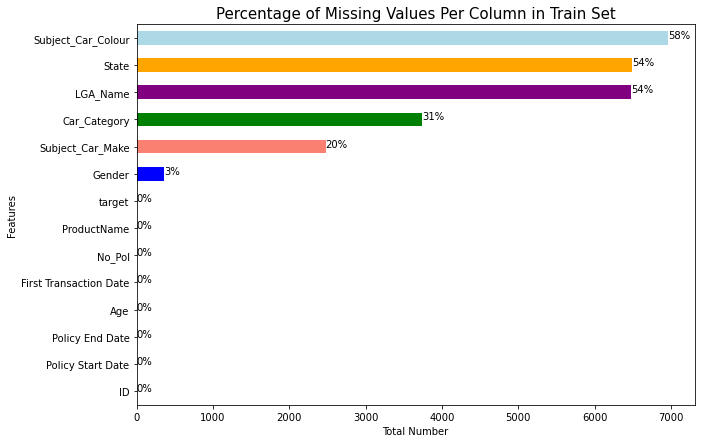

In [17]:
# Visualizing the missing values in the training dataset
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7),
                                           color=['indigo', 'yellow', 'brown', 'pink',
                                                 'cyan', 'gray', 'olive', 'orangered',
                                                 'blue', 'salmon', 'green', 'purple',
                                                 'orange','lightblue', 'red', 'violet'])

# Add some attributes
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
plt.xlabel('Total Number')
plt.ylabel('Features')

for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y));

In [18]:
# Check for missing values in the test dataset
test.isna().sum()

ID                          0
Policy Start Date           0
Policy End Date             0
Gender                     41
Age                         0
First Transaction Date      0
No_Pol                      0
Car_Category              372
Subject_Car_Colour        697
Subject_Car_Make          248
LGA_Name                  656
State                     656
ProductName                 0
dtype: int64

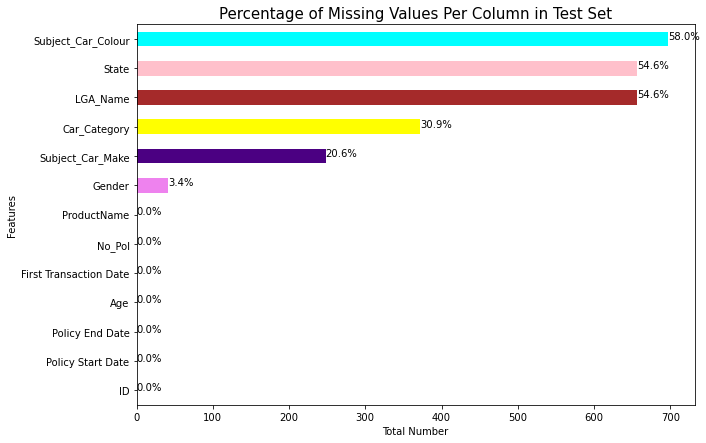

In [19]:
# Visualizing the missing values in the test dataset
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7),
                                          color=['blue', 'salmon', 'green', 'purple',
                                                                  'orange','lightblue', 'red', 'violet',
                                                                  'indigo', 'yellow', 'brown', 'pink',
                                                                  'cyan', 'gray', 'olive', 'orangered'])

# Add some attributes
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})
plt.xlabel('Total Number')
plt.ylabel('Features')

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Combine Train and Test Set for Easy Preprocessing 

In [20]:
# Combining the training and test dataset
ntrain = train.shape[0]# to be used to split train and test set from the combined dataframe
ntest=test.shape[0]

alldata = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {alldata.shape}')

The shape of the combined dataframe is: (13281, 14)


In [21]:
# Preview the bottom five rows of the combined dataframe
alldata.head(50)

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0.0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1.0
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0.0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0.0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1.0
5,ID_00D3EF6,2010-10-21,2011-10-20,Male,37,2010-10-21,2,NaN,NaN,NaN,NaN,NaN,Car Classic,0.0
6,ID_00HHZ8Y,2010-08-02,2011-08-01,Female,40,2010-08-02,3,NaN,NaN,NaN,Ikeja,Lagos,CVTP,0.0
7,ID_00M1X6U,2010-09-12,2011-09-11,Male,43,2010-09-12,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe,0.0
8,ID_00N7XT1,2010-07-06,2011-07-05,Female,71,2010-07-06,2,JEEP,Black,REXTON,Badagry,Benue,Car Classic,0.0
9,ID_00QF156,2010-12-18,2011-12-17,Female,58,2010-12-18,1,NaN,NaN,NaN,Eti-Osa,Eti-Osa,Car Classic,0.0


In [22]:
alldata.describe()

,Age,No_Pol,target
count,13281.000000,13281.000000,12079.000000
mean,42.375574,1.302763,0.120457
std,93.170951,0.723195,0.325509
min,-6099.000000,1.000000,0.000000
25%,35.000000,1.000000,0.000000
50%,41.000000,1.000000,0.000000
75%,50.000000,1.000000,0.000000
max,320.000000,10.000000,1.000000


### Insurance Claim According to No_Pol

In [23]:
alldata.No_Pol.value_counts()

1     10552
2      1864
3       590
4       214
5        25
7        19
10        9
6         8
Name: No_Pol, dtype: int64

<AxesSubplot:xlabel='No_Pol', ylabel='Density'>

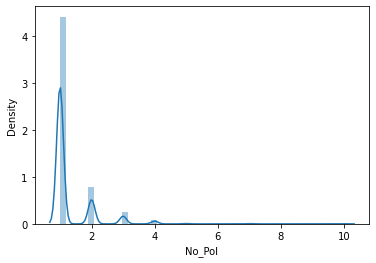

In [24]:
# Histogram showing the distribution of the Number of Policy column
sns.distplot(alldata.No_Pol.dropna())

Text(0.5, 1.0, 'Boxplot Before Removing Outliers')

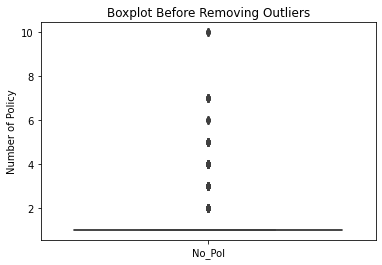

In [25]:
# Make a boxplot of number of policy to detect outliers
No_Pol = sns.boxplot(data=alldata.loc[:, ['No_Pol']])
_ = No_Pol.set_ylabel('Number of Policy')
plt.title('Boxplot Before Removing Outliers')

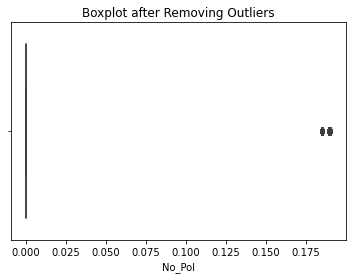

In [26]:
# Applying box transformation to remove the outliers
alldata['No_Pol'],fitted_lambda=scipy.stats.boxcox(alldata['No_Pol'], lmbda=None)
sns.boxplot(alldata['No_Pol'])
plt.title('Boxplot after Removing Outliers')
plt.show()

In [27]:
alldata['No_Pol'][:15]

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.189627
5     0.185243
6     0.189627
7     0.000000
8     0.185243
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.185243
14    0.000000
Name: No_Pol, dtype: float64

### Insurance Claim According to Age

In [28]:
alldata.Age.value_counts()

 40      900
 50      686
 41      550
 36      537
 38      514
        ... 
 140       1
-27        1
-51        1
 133       1
-6099      1
Name: Age, Length: 110, dtype: int64

In [29]:
alldata['Age'][:20]

0      30
1      79
2      43
3       2
4      20
5      37
6      40
7      43
8      71
9      58
10     43
11     45
12     51
13    120
14     38
15     81
16     69
17     31
18     70
19     20
Name: Age, dtype: int64

In [30]:
age = 2021 - alldata['Age']

<AxesSubplot:xlabel='Age', ylabel='Density'>

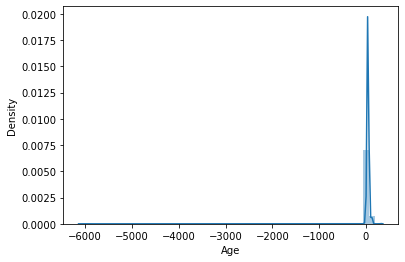

In [31]:
# Histogram showing the distribution of the Age column
sns.distplot(alldata.Age.dropna())

Text(0.5, 1.0, 'Boxplot of Age Before Removing Outliers')

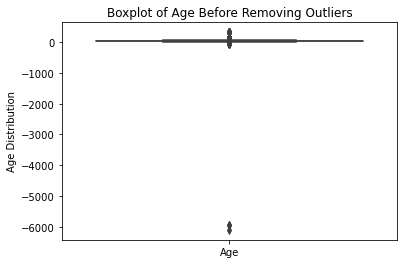

In [33]:
# Make a boxplot of Age to detect outliers
age = sns.boxplot(data=alldata.loc[:, ['Age']])
_ = age.set_ylabel('Age Distribution')
plt.title('Boxplot of Age Before Removing Outliers')

In [34]:
# # Removing the outliers from the Age column using log transform
# alldata['Age'] = np.log(alldata['Age'])
# sns.distplot(alldata['Age'])
# plt.title('Distribution Plot of Age after Log Transform')
# sns.despine()
# plt.show()

### Insurance Claim According to Gender

To compare two columns to each other, use the function pd.crosstab(column_1, column_2).

This is helpful if i want to start gaining an intuition about how the independent variables interact with the dependent variables.

Compare our target column with the sex column.

For the target column, 1 = customers that will submit a vehicle insurance claim within next three months from their first transaction, 0 = customers that will not submit a vehicle insurance claim within next three months from their first transaction.

In [35]:
alldata.Gender.value_counts()

Male            8356
Female          3679
Entity           300
Joint Gender     238
NOT STATED       190
NO GENDER         76
SEX               42
Name: Gender, dtype: int64

In [36]:
# Replace gender that is not male or female with other
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
alldata.Gender = alldata.Gender.replace(mapper)

# Confirm mappings
alldata.Gender.value_counts()

Male      8356
Female    3679
Other      846
Name: Gender, dtype: int64

In [37]:
alldata['Gender'] = alldata['Gender'].replace({'Other': np.nan})
alldata['Gender']

0          Male
1        Female
2          Male
3          Male
4           NaN
          ...  
13276      Male
13277      Male
13278      Male
13279      Male
13280      Male
Name: Gender, Length: 13281, dtype: object

In [38]:
# Drop cases where either variable is missing
data = alldata[['Gender', 'target']].dropna() 
pd.crosstab(data.Gender, data.target)

target,0.0,1.0
Gender,,
Female,2969,358
Male,6715,902


**Observation:**

Since there are 3679 females, 2969 females will not claim insurance in the first 3 months and 358 of them will claim insurance in the first 3 months, we might infer, based on this one variable if the customer is a woman, there's a 9.7% chance she will claim insurance in the first 3 months.

As for males, there are 8356 males, 6715 males will not claim insurance in the first 3 months and 902 of them will claim insurance in the first 3 months. So we might predict, if the participant is male, there is a 10.8% chance he will claim insurance in the first 3 months.

Averaging these two values, we can assume, based on no other parameters, if there's a person, there's a 10.2% chance they will claim insurance in the first 3 months.

### Distribution of the Gender Column

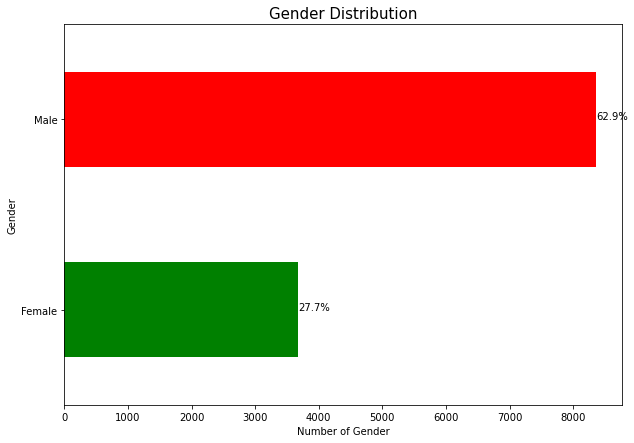

In [39]:
# Gender Distribution
ax = alldata.Gender.value_counts().sort_values().plot(kind = 'barh', figsize=(10, 7), color=['green', 'red'])

# Add some attributes
plt.title('Gender Distribution', fontdict={'size': 15})
plt.xlabel('Number of Gender')
plt.ylabel('Gender')

for p in ax.patches:
    percentage = '{:,.1f}%'.format((p.get_width()/alldata.shape[0]) * 100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage,(x, y));

**Observation:**

From the horizontal bar chart above, 62.9% of the customers are males, 27.7% of the customers are females.

### Insurance Claim According to Car_Category

In [40]:
alldata.Car_Category.value_counts()

Saloon                     6633
JEEP                       2223
Truck                       108
Bus                          56
Mini Bus                     45
Pick Up                      32
Motorcycle                   18
Sedan                        14
Mini Van                     13
Wagon                        10
Shape Of Vehicle Chasis       6
Station 4 Wheel               6
Van                           3
Pick Up > 3 Tons              2
CAMRY CAR HIRE                1
Tipper Truck                  1
Name: Car_Category, dtype: int64

In [41]:
# Compare the target column to car_category
pd.crosstab(alldata.Car_Category, alldata.target)

target,0.0,1.0
Car_Category,,
Bus,45,9
CAMRY CAR HIRE,1,0
JEEP,1773,248
Mini Bus,26,10
Mini Van,11,2
Motorcycle,15,2
Pick Up,22,8
Pick Up > 3 Tons,1,0
Saloon,5219,815


### Distribution of the Car_Category Column

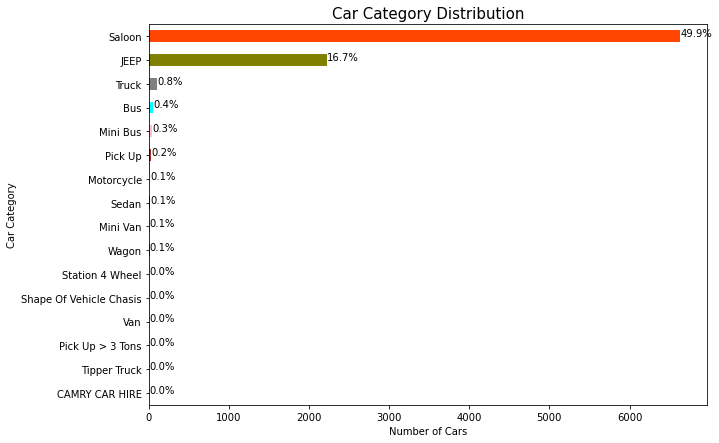

In [42]:
# Car_category Distribution
ax = alldata.Car_Category.value_counts().sort_values().plot(kind='barh', 
                                                            figsize=(10, 7), 
                                                            color=['blue', 'salmon', 'green', 'purple',
                                                                  'orange','lightblue', 'red', 'violet',
                                                                  'indigo', 'yellow', 'brown', 'pink',
                                                                  'cyan', 'gray', 'olive', 'orangered'])

# Add some attributes
plt.title('Car Category Distribution', fontdict={'size': 15})
plt.xlabel('Number of Cars')
plt.ylabel('Car Category')

for p in ax.patches:
    percentage = '{:,.1f}%'.format((p.get_width()/alldata.shape[0]) * 100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage,(x, y));

**Observation**:

From the horizontal barchart of the car category, 49.9% of all vehicles insured by AutoInland Vehicle Insurance are saloon cars, 16.7% of all vehicles insured by AutoInland Vehicle Insurance are Jeeps, 0.8% of all vehicles insured by AutoInland Vehicle Insurance are Trucks, 0.4% of all vehicles insured by AutoInland Vehicle Insurance are Buses, 0.3% of all vehicles insured by AutoInland Vehicle Insurance are Mini Buses, 0.2% of all vehicles insured by AutoInland Vehicle Insurance are Pick Ups, 0.1% are motorcycles, sedans, Mini vans and wagons.

### Insurance Claim According to Subject_Car_Make

In [43]:
alldata.Subject_Car_Make.value_counts()

TOYOTA        5466
Honda         1146
Lexus          654
Mercedes       577
Hyundai        512
              ... 
CHANGAN          1
BRILLIANCE       1
Motorcycle       1
ZOYTE            1
Bajaj            1
Name: Subject_Car_Make, Length: 75, dtype: int64

In [44]:
# Compare the target column to subject car make
pd.crosstab(alldata.Subject_Car_Make, alldata.target)

target,0.0,1.0
Subject_Car_Make,,
.,30,14
ABG,1,0
ACURA,58,7
As Attached,6,5
Ashok Leyland,1,0
...,...,...
Volkswagen,117,5
Volvo,29,8
Wrangler Jeep,2,0


### Distribution of the Subject_Car_Make Column

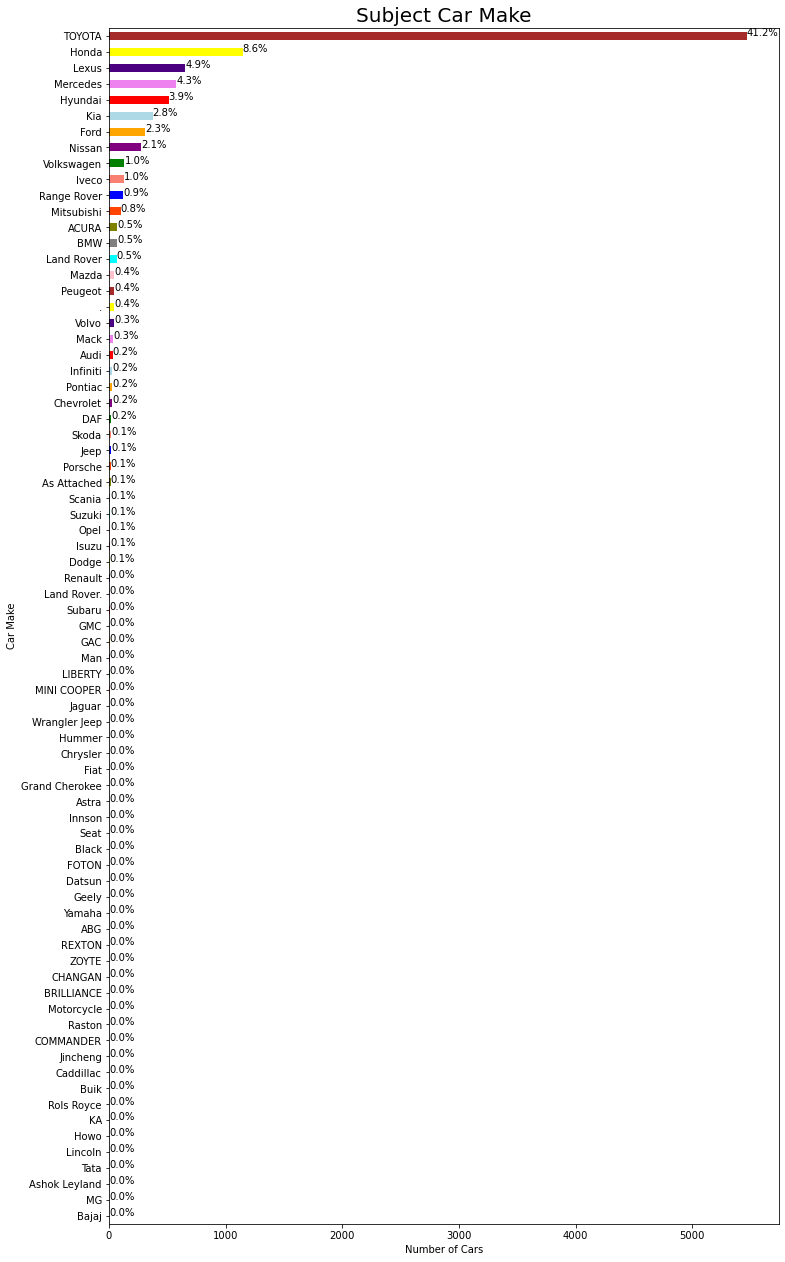

In [45]:
# Subject car make Distribution
ax = alldata.Subject_Car_Make.value_counts().sort_values().plot(kind='barh', 
                                                            figsize=(12, 22), 
                                                            color=['blue', 'salmon', 'green', 'purple',
                                                                  'orange','lightblue', 'red', 'violet',
                                                                  'indigo', 'yellow', 'brown', 'pink',
                                                                  'cyan', 'gray', 'olive', 'orangered'])

# Add some attributes
plt.title('Subject Car Make', fontdict={'size': 20})
plt.xlabel('Number of Cars')
plt.ylabel('Car Make')

for p in ax.patches:
    percentage = '{:,.1f}%'.format((p.get_width()/alldata.shape[0]) * 100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage,(x, y));

**Observation**:

From the horizontal barchart of the car category, 41.2% of all vehicles insured by AutoInland Vehicle Insurance are Toyota cars, 8.6% of all vehicles insured by AutoInland Vehicle Insurance are Honda cars, 4.9% of all vehicles insured by AutoInland Vehicle Insurance are Lexus cars, 4.3% of all vehicles insured by AutoInland Vehicle Insurance are Mercedes cars, 3.9% of all vehicles insured by AutoInland Vehicle Insurance are Hyundai cars, 2.8% of all vehicles insured by AutoInland Vehicle Insurance are Kia cars,2.3% of all vehicles insured by AutoInland Vehicle Insurance are Ford cars, 2.1% of all vehicles insured by AutoInland Vehicle Insurance are Nissan cars, 1.0% of all vehicles insured by AutoInland Vehicle Insurance are Volkswagen cars and Iveco etc

### Insurance Claim According to State

In [46]:
alldata.State.value_counts()

Lagos              3494
Benue               693
Abuja-Municipal     257
Eti-Osa             241
Ibeju-Lekki         129
                   ... 
Ndokwa-East           1
Idemili-south         1
Ethiope-East          1
Bauchi                1
Nasarawa              1
Name: State, Length: 113, dtype: int64

In [47]:
# Compare the target column to State
pd.crosstab(alldata.State, alldata.target)

target,0.0,1.0
State,,
ABULE-EGBA,5,1
AJAO-ESTATE,2,0
Aba-North,3,0
Aba-South,1,0
Abia,2,0
...,...,...
Ughelli-North,1,0
Umuahia-South,2,0
Warri-Central,23,4


In [48]:
# Compare the target column to State
pd.crosstab(alldata.State, alldata.target)

target,0.0,1.0
State,,
ABULE-EGBA,5,1
AJAO-ESTATE,2,0
Aba-North,3,0
Aba-South,1,0
Abia,2,0
...,...,...
Ughelli-North,1,0
Umuahia-South,2,0
Warri-Central,23,4


In [49]:
# Compare the target column to State
pd.crosstab(alldata.State, alldata.target)

target,0.0,1.0
State,,
ABULE-EGBA,5,1
AJAO-ESTATE,2,0
Aba-North,3,0
Aba-South,1,0
Abia,2,0
...,...,...
Ughelli-North,1,0
Umuahia-South,2,0
Warri-Central,23,4


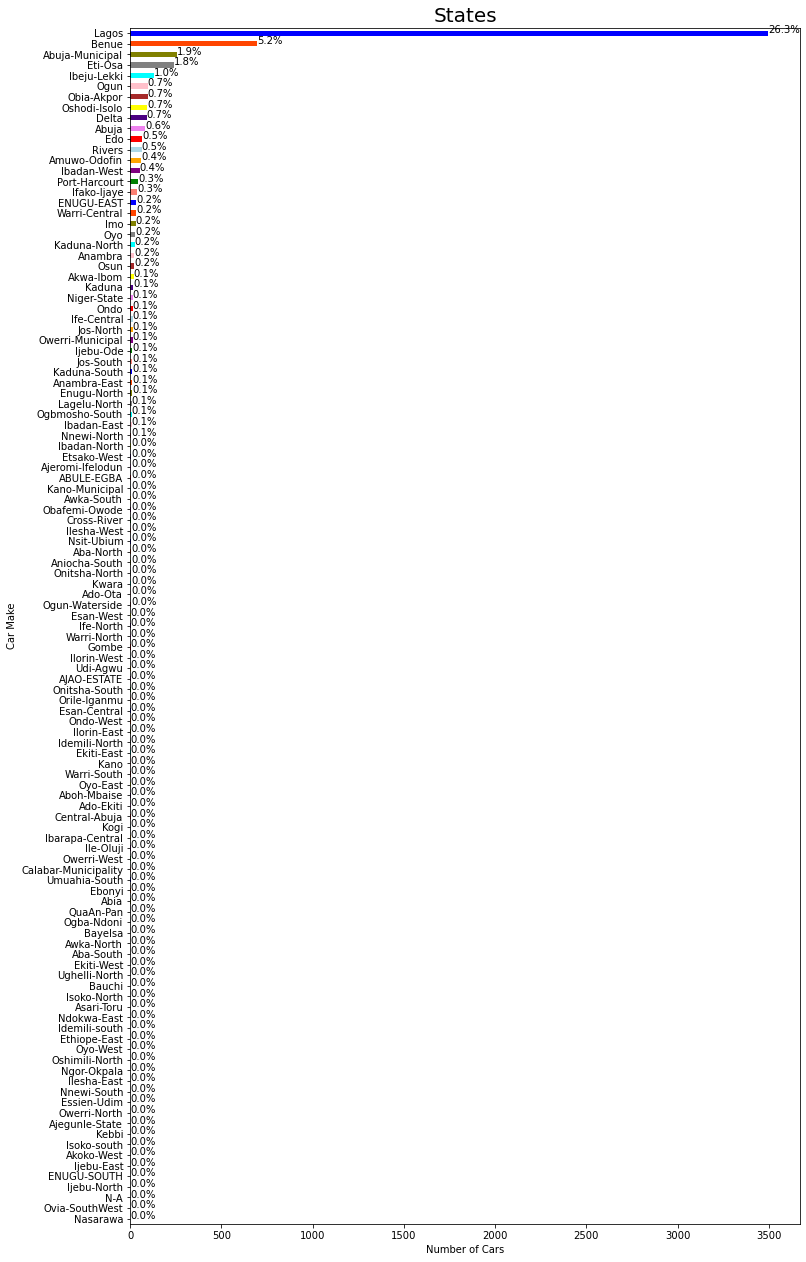

In [50]:
# State Distribution
ax = alldata.State.value_counts().sort_values().plot(kind='barh', 
                                                            figsize=(12, 22), 
                                                            color=['blue', 'salmon', 'green', 'purple',
                                                                  'orange','lightblue', 'red', 'violet',
                                                                  'indigo', 'yellow', 'brown', 'pink',
                                                                  'cyan', 'gray', 'olive', 'orangered'])

# Add some attributes
plt.title('States', fontdict={'size': 20})
plt.xlabel('Number of Cars')
plt.ylabel('Car Make')

for p in ax.patches:
    percentage = '{:,.1f}%'.format((p.get_width()/alldata.shape[0]) * 100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage,(x, y));

**Observation**:

From the horizontal barchart of the car category, 26.3% of all vehicles insured by AutoInland Vehicle Insurance are insured in Lagos state, 5.2% of all vehicles insured by AutoInland Vehicle Insurance are insured in Benue state etc.


Plot the target column value counts by calling the plot() function and telling it what kind of plot we'd like, bar plot is preferable

In [51]:
# Let's see how many positive (1) and negative (0) samples we have in our dataframe
print('Length of the concatenated dataset:', len(alldata))
print('Total no of customers that will not claim insurance in the first 3 months:', len(alldata[alldata['target']==0]))
print('Total no of customers that will claim insurance in the first 3 months:', len(alldata[alldata['target']==1]))

Length of the concatenated dataset: 13281
Total no of customers that will not claim insurance in the first 3 months: 10624
Total no of customers that will claim insurance in the first 3 months: 1455


In [52]:
# Check the shape of the concatenated dataset
print(f'The shape of the concatenated dataset is: {alldata.shape}')

The shape of the concatenated dataset is: (13281, 14)


In [53]:
alldata['target'].value_counts(normalize=True)

0.0    0.879543
1.0    0.120457
Name: target, dtype: float64

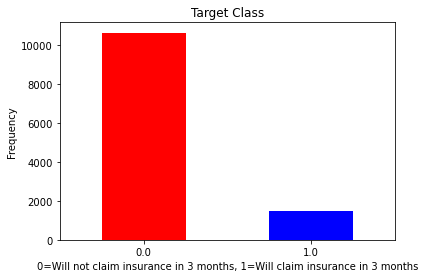

In [54]:
# Plot the target value counts with a bar graph
alldata.target.value_counts().plot(kind='bar', title = 'Target Class', color=['red', 'blue'])
plt.xlabel('0=Will not claim insurance in 3 months, 1=Will claim insurance in 3 months')
plt.ylabel('Frequency')
plt.xticks(rotation=0);

In [55]:
alldata.isna().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                    1246
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              4110
Subject_Car_Colour        7659
Subject_Car_Make          2724
LGA_Name                  7132
State                     7144
ProductName                  0
target                    1202
dtype: int64

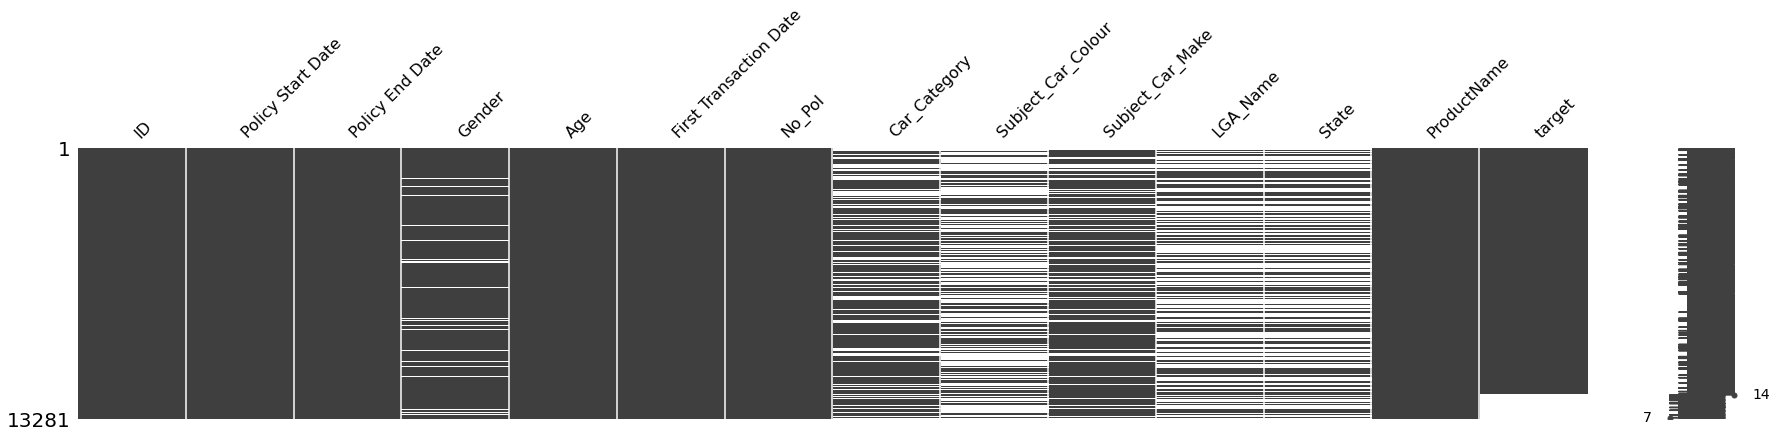

In [56]:
# Visualizing the missing values in the dataset
missingno.matrix(alldata, figsize=(30, 5));

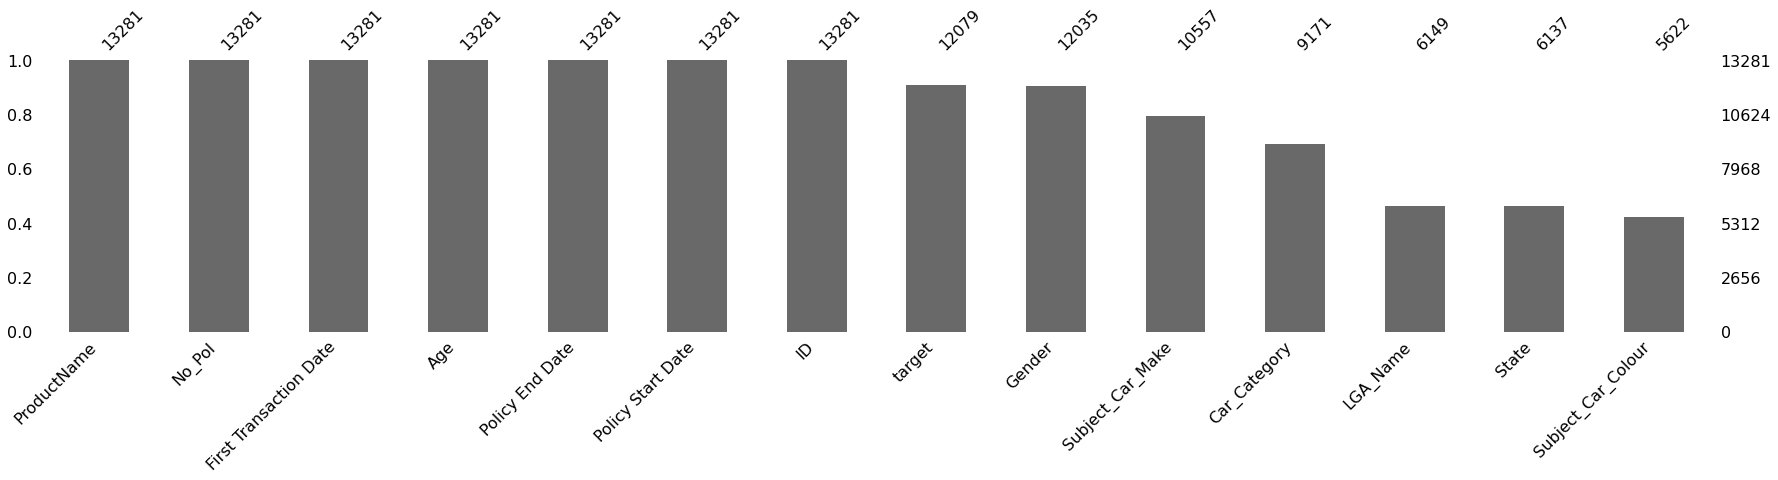

In [57]:
missingno.bar(alldata, sort='descending', figsize=(30, 5));

In [58]:
# No parse_dates... check dtype of "Policy_Start_Date, Policy_End_Date, First_Transaction_Date"
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      13281 non-null  object 
 1   Policy Start Date       13281 non-null  object 
 2   Policy End Date         13281 non-null  object 
 3   Gender                  12035 non-null  object 
 4   Age                     13281 non-null  int64  
 5   First Transaction Date  13281 non-null  object 
 6   No_Pol                  13281 non-null  float64
 7   Car_Category            9171 non-null   object 
 8   Subject_Car_Colour      5622 non-null   object 
 9   Subject_Car_Make        10557 non-null  object 
 10  LGA_Name                6149 non-null   object 
 11  State                   6137 non-null   object 
 12  ProductName             13281 non-null  object 
 13  target                  12079 non-null  float64
dtypes: float64(2), int64(1), object(11)
me

### Rename the Date Column

In [59]:
# Rename the Date columns
alldata.rename(columns = {'Policy Start Date': 'PolicyStartDate',
                          'Policy End Date': 'PolicyEndDate',
                          'First Transaction Date': 'FirstTransactionDate',
                          'ProductName': 'ProductName'},
                           inplace=True)
alldata.head()

,ID,PolicyStartDate,PolicyEndDate,Gender,Age,FirstTransactionDate,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,0.000000,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0.0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,0.000000,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1.0
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,0.000000,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0.0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,0.000000,NaN,NaN,NaN,NaN,NaN,CarSafe,0.0
4,ID_00BRP63,2010-08-29,2010-12-31,NaN,20,2010-08-29,0.189627,NaN,NaN,NaN,Lagos,Lagos,Muuve,1.0


### Save Preprocessed data

In [60]:
# Save pre-processed data
alldata.to_csv('AutoInland-Vehicle-insurance-claim-challenge/alldata.csv', index=False)

In [61]:
# import preprocessed data with parse date
alldata = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/alldata.csv',
                      low_memory=False,
                      parse_dates=['PolicyStartDate', 'PolicyEndDate', 'FirstTransactionDate'])
alldata.head().T

,0,1,2,3,4
ID,ID_0040R73,ID_0046BNK,ID_005QMC3,ID_0079OHW,ID_00BRP63
PolicyStartDate,2010-05-14 00:00:00,2010-11-29 00:00:00,2010-03-21 00:00:00,2010-08-21 00:00:00,2010-08-29 00:00:00
PolicyEndDate,2011-05-13 00:00:00,2011-11-28 00:00:00,2011-03-20 00:00:00,2011-08-20 00:00:00,2010-12-31 00:00:00
Gender,Male,Female,Male,Male,NaN
Age,30,79,43,2,20
FirstTransactionDate,2010-05-14 00:00:00,2010-11-29 00:00:00,2010-03-21 00:00:00,2010-08-21 00:00:00,2010-08-29 00:00:00
No_Pol,0.0,0.0,0.0,0.0,0.189627
Car_Category,Saloon,JEEP,Saloon,NaN,NaN
Subject_Car_Colour,Black,Grey,Red,NaN,NaN
Subject_Car_Make,TOYOTA,TOYOTA,TOYOTA,NaN,NaN


### 4. Feature Cleaning, Engineering, and Imputation

**Cleaning**: To clean our data, we'll need to work with:

* **Missing values**: Either omit elements from a dataset that contain missing values or impute them (fill them in).
* **Special values**: Numeric variables are endowed with several formalized special values including ±Inf, NA and NaN. Calculations involving special values often result in special values, and need to be handled/cleaned.
* **Outliers**: They should be detected, but not necessarily removed. Their inclusion in the analysis is a statistical decision.
* **Obvious inconsistencies**: A person's age cannot be negative, a man cannot be pregnant and an under-aged person cannot possess a drivers license. Find the inconsistencies and plan for them.

**Engineering**: There are multiple techniques for feature engineering:

* **Decompose**: Converting 2014-09-20T20:45:40Z into categorical attributes like hour_of_the_day, part_of_day, etc.

**Imputation**: We can impute missing values in a number of different ways:

* **Hot-Deck**: The technique then finds the first missing value and uses the cell value immediately prior to the data that are missing to impute the missing value.
* **Cold-Deck**: Selects donors from another dataset to complete missing data.
* **Mean-substitution**: Another imputation technique involves replacing any missing value with the mean of that variable for all other cases, which has the benefit of not changing the sample mean for that variable.
* **Regression**: A regression model is estimated to predict observed values of a variable based on other variables, and that model is then used to impute values in cases where that variable is missing.

### Parsing dates

When working with data that has dates, it's a good idea to make sure any date data is the format of a datetime object (a Python data type which encodes specific information about dates).

In [62]:
# With parse_dates... check dtype of "Policy_Start_Date, Policy_End_Date, First_Transaction_Date"
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID                    13281 non-null  object        
 1   PolicyStartDate       13281 non-null  datetime64[ns]
 2   PolicyEndDate         13281 non-null  datetime64[ns]
 3   Gender                12035 non-null  object        
 4   Age                   13281 non-null  int64         
 5   FirstTransactionDate  13281 non-null  datetime64[ns]
 6   No_Pol                13281 non-null  float64       
 7   Car_Category          9171 non-null   object        
 8   Subject_Car_Colour    5622 non-null   object        
 9   Subject_Car_Make      10557 non-null  object        
 10  LGA_Name              6149 non-null   object        
 11  State                 6137 non-null   object        
 12  ProductName           13281 non-null  object        
 13  target          

We've turned the `PolicyStartDate`, `PolicyEndDate`, `FirstTransactionDate` column from object datatype to datetime64 datatype.

In [63]:
alldata.PolicyStartDate.head(10)

0   2010-05-14
1   2010-11-29
2   2010-03-21
3   2010-08-21
4   2010-08-29
5   2010-10-21
6   2010-08-02
7   2010-09-12
8   2010-07-06
9   2010-12-18
Name: PolicyStartDate, dtype: datetime64[ns]

### Sort DataFrame by PolicyStartDate, PolicyEndDate, FirstTransactionDate

As we're working dates and trying to predict future examples given past examples, it makes sense to sort our data by date.

In [64]:
# Sort Dataframe by date PolicyStartDate
alldata.sort_values(by=['PolicyStartDate'], inplace=True, ascending=True)
alldata.PolicyStartDate.head(10)

8010    2001-12-11
10526   2002-03-25
10234   2003-04-13
12066   2003-12-21
8124    2005-08-05
10708   2006-03-24
4442    2006-07-06
912     2007-03-04
2076    2009-02-26
6239    2009-08-29
Name: PolicyStartDate, dtype: datetime64[ns]

In [65]:
# Sort DataFrame by PolicyEndDate
alldata.sort_values(by=['PolicyEndDate'], inplace=True, ascending=True)
alldata.PolicyEndDate.head(10)

2316    2010-12-31
6050    2010-12-31
7050    2010-12-31
4778    2010-12-31
11110   2010-12-31
4138    2010-12-31
3779    2010-12-31
12819   2010-12-31
8975    2010-12-31
10219   2010-12-31
Name: PolicyEndDate, dtype: datetime64[ns]

In [66]:
# Sort DataFrame by FirstTransactionDate
alldata.sort_values(by=['FirstTransactionDate'], inplace=True, ascending=True)
alldata.FirstTransactionDate.head(10)

8010    2001-12-11
10526   2002-03-25
10234   2003-04-13
12066   2003-12-21
8124    2005-08-05
10708   2006-03-24
4442    2006-07-06
912     2007-03-04
2076    2009-02-26
6239    2009-08-29
Name: FirstTransactionDate, dtype: datetime64[ns]

### Add datetime parameters for PolicyStartDate, PolicyEndDate, FirstTransactionDate column

Why?

So we can enrich our dataset with as much information as possible.

Because we imported the data using `alldata_csv()` and we asked pandas to parse the dates using parse_dates=[`'PolicyStartDate'`, `'PolicyEndDate'`, `'FirstTransactionDate'`]), we can now access the different datetime attributes https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html of the date column.

In [67]:
# Add datetime for PolicyStartDate
alldata['PolicyStartYear'] = alldata.PolicyStartDate.dt.year
alldata['PolicyStartMonth'] = alldata.PolicyStartDate.dt.month
alldata['PolicyStartDay'] = alldata.PolicyStartDate.dt.day
alldata['PolicyStartDayofweek'] = alldata.PolicyStartDate.dt.dayofweek
alldata['PolicyStartDayofyear'] = alldata.PolicyStartDate.dt.dayofyear

# Drop original PolicyStartDate
alldata.drop("PolicyStartDate", axis=1, inplace=True)

In [68]:
# Add datetime for PolicyEndDate
alldata['PolicyEndYear'] = alldata.PolicyEndDate.dt.year
alldata['PolicyEndMonth'] = alldata.PolicyEndDate.dt.month
alldata['PolicyEndDay'] = alldata.PolicyEndDate.dt.day
alldata['PolicyEndDayofweek'] = alldata.PolicyEndDate.dt.dayofweek
alldata['PolicyEndDayofyear'] = alldata.PolicyEndDate.dt.dayofyear

# Drop original PolicyEndDate
alldata.drop("PolicyEndDate", axis=1, inplace=True)

In [69]:
# Add datetime for FirstTransactionDate
alldata['FirstTransactionYear'] = alldata.FirstTransactionDate.dt.year
alldata['FirstTransactionMonth'] = alldata.FirstTransactionDate.dt.month
alldata['FirstTransactionDay'] = alldata.FirstTransactionDate.dt.day
alldata['FirstTransactionDayofweek'] = alldata.FirstTransactionDate.dt.dayofweek
alldata['FirstTransactionDayofyear'] = alldata.FirstTransactionDate.dt.dayofyear

# Drop original FirstTransactionDate
alldata.drop("FirstTransactionDate", axis=1, inplace=True)

In [70]:
alldata.reset_index(drop=True)

,ID,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,...,PolicyEndYear,PolicyEndMonth,PolicyEndDay,PolicyEndDayofweek,PolicyEndDayofyear,FirstTransactionYear,FirstTransactionMonth,FirstTransactionDay,FirstTransactionDayofweek,FirstTransactionDayofyear
0,ID_O51ZQ1B,Female,37,0.000000,Saloon,Black,Honda,NaN,NaN,Car Vintage,...,2011,12,10,5,344,2001,12,11,1,345
1,ID_VJ1FAVO,Male,37,0.000000,Saloon,Black,TOYOTA,Ekiti,Benue,Car Classic,...,2011,3,24,3,83,2002,3,25,0,84
2,ID_ULWS8VL,Male,41,0.185243,Saloon,Black,TOYOTA,Ikeja,Lagos,Car Vintage,...,2011,4,12,1,102,2003,4,13,6,103
3,ID_ZYKGSP7,Male,48,0.185243,Saloon,NaN,BMW,NaN,NaN,Car Vintage,...,2034,5,20,5,140,2003,12,21,6,355
4,ID_OEWBKGF,Female,44,0.000000,NaN,NaN,Tata,Ajah,Lagos,CVTP,...,2011,9,29,3,272,2005,8,5,4,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13276,ID_XR8F115,Male,37,0.000000,JEEP,NaN,Hyundai,NaN,NaN,CarSafe,...,2011,12,30,4,364,2010,12,31,4,365
13277,ID_VX91XCX,Female,50,0.000000,NaN,NaN,NaN,NaN,NaN,CarSafe,...,2011,12,30,4,364,2010,12,31,4,365
13278,ID_8MNXRC6,Male,36,0.000000,Saloon,Silver,Kia,Anthony Village,Lagos,Car Classic,...,2011,12,16,4,350,2010,12,31,4,365
13279,ID_V1RSMQM,NaN,51,0.000000,NaN,Brown,Range Rover,Victoria Island,Lagos,Car Classic,...,2011,12,30,4,364,2010,12,31,4,365


In [71]:
alldata.head().T

,8010,10526,10234,12066,8124
ID,ID_O51ZQ1B,ID_VJ1FAVO,ID_ULWS8VL,ID_ZYKGSP7,ID_OEWBKGF
Gender,Female,Male,Male,Male,Female
Age,37,37,41,48,44
No_Pol,0.0,0.0,0.185243,0.185243,0.0
Car_Category,Saloon,Saloon,Saloon,Saloon,NaN
Subject_Car_Colour,Black,Black,Black,NaN,NaN
Subject_Car_Make,Honda,TOYOTA,TOYOTA,BMW,Tata
LGA_Name,NaN,Ekiti,Ikeja,NaN,Ajah
State,NaN,Benue,Lagos,NaN,Lagos
ProductName,Car Vintage,Car Classic,Car Vintage,Car Vintage,CVTP


In [72]:
# Check for missing values
alldata.isna().sum()

ID                              0
Gender                       1246
Age                             0
No_Pol                          0
Car_Category                 4110
Subject_Car_Colour           7659
Subject_Car_Make             2724
LGA_Name                     7132
State                        7144
ProductName                     0
target                       1202
PolicyStartYear                 0
PolicyStartMonth                0
PolicyStartDay                  0
PolicyStartDayofweek            0
PolicyStartDayofyear            0
PolicyEndYear                   0
PolicyEndMonth                  0
PolicyEndDay                    0
PolicyEndDayofweek              0
PolicyEndDayofyear              0
FirstTransactionYear            0
FirstTransactionMonth           0
FirstTransactionDay             0
FirstTransactionDayofweek       0
FirstTransactionDayofyear       0
dtype: int64

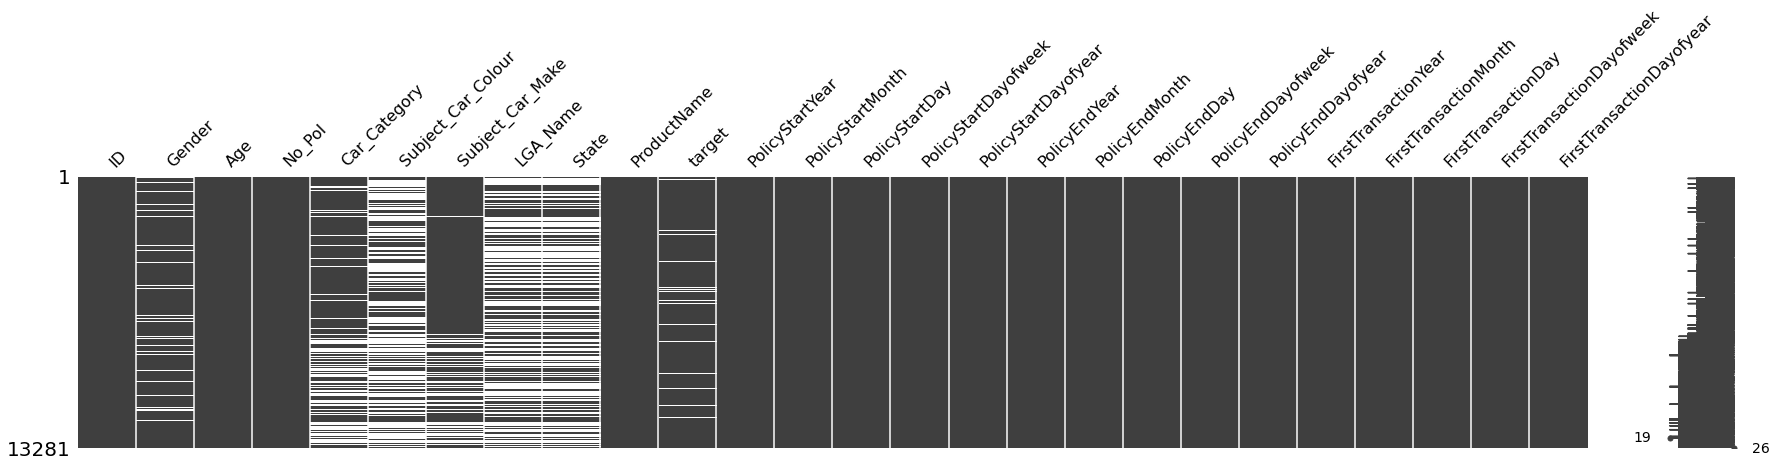

In [73]:
# Visualizing the missing values in the dataset
missingno.matrix(alldata, figsize=(30, 5));

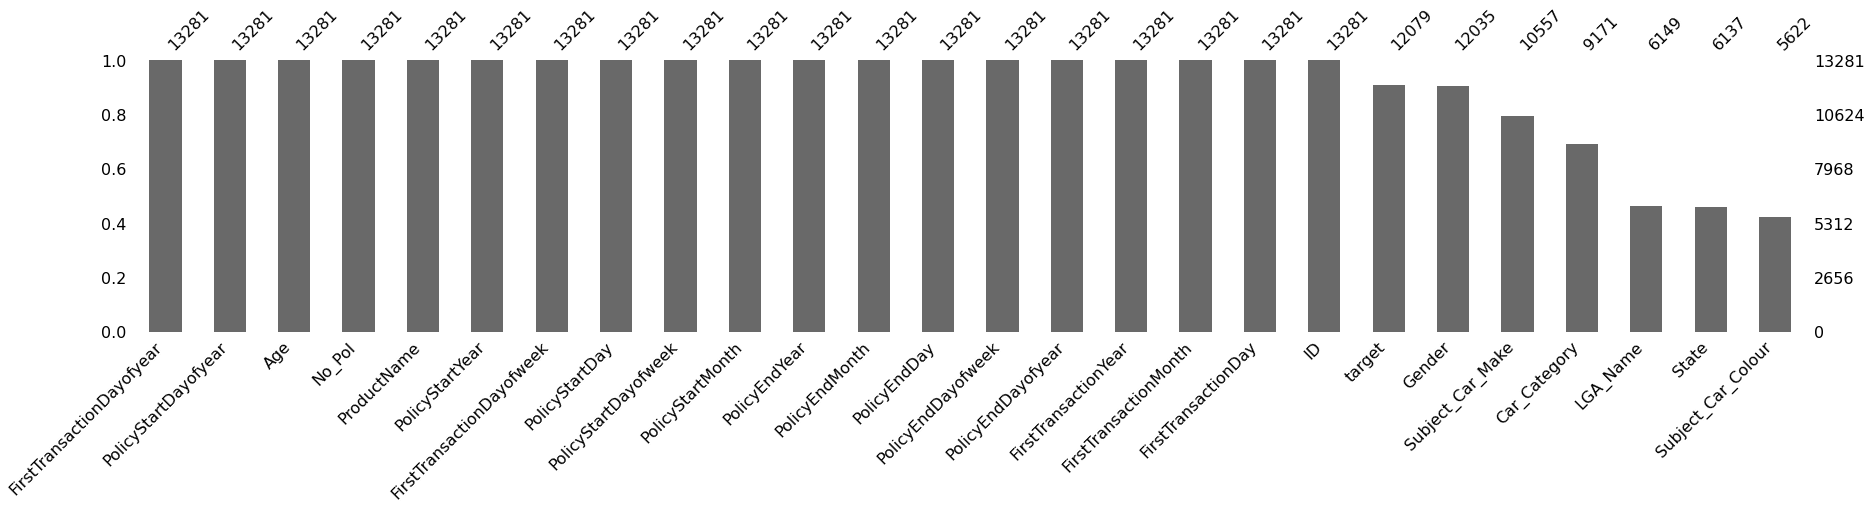

In [74]:
missingno.bar(alldata, sort='descending', figsize=(30, 5));

In [75]:
alldata.head().T

,8010,10526,10234,12066,8124
ID,ID_O51ZQ1B,ID_VJ1FAVO,ID_ULWS8VL,ID_ZYKGSP7,ID_OEWBKGF
Gender,Female,Male,Male,Male,Female
Age,37,37,41,48,44
No_Pol,0.0,0.0,0.185243,0.185243,0.0
Car_Category,Saloon,Saloon,Saloon,Saloon,NaN
Subject_Car_Colour,Black,Black,Black,NaN,NaN
Subject_Car_Make,Honda,TOYOTA,TOYOTA,BMW,Tata
LGA_Name,NaN,Ekiti,Ikeja,NaN,Ajah
State,NaN,Benue,Lagos,NaN,Lagos
ProductName,Car Vintage,Car Classic,Car Vintage,Car Vintage,CVTP


In [76]:
# Check for missing categories and different datatypes
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13281 entries, 8010 to 2746
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         13281 non-null  object 
 1   Gender                     12035 non-null  object 
 2   Age                        13281 non-null  int64  
 3   No_Pol                     13281 non-null  float64
 4   Car_Category               9171 non-null   object 
 5   Subject_Car_Colour         5622 non-null   object 
 6   Subject_Car_Make           10557 non-null  object 
 7   LGA_Name                   6149 non-null   object 
 8   State                      6137 non-null   object 
 9   ProductName                13281 non-null  object 
 10  target                     12079 non-null  float64
 11  PolicyStartYear            13281 non-null  int64  
 12  PolicyStartMonth           13281 non-null  int64  
 13  PolicyStartDay             13281 non-null  i

### Convert the strings into categories

In [77]:
# Find the columns which contains strings
for label, content in alldata.drop('ID', axis=1).items():
    if pd.api.types.is_string_dtype(content):
        print(label)

Gender
Car_Category
Subject_Car_Colour
Subject_Car_Make
LGA_Name
State
ProductName


In [78]:
# This will turn all strings values into categories
for label, content in alldata.items():
    if pd.api.types.is_string_dtype(content):
        alldata[label]=content.astype('category').cat.as_ordered()

In [79]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13281 entries, 8010 to 2746
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   ID                         13281 non-null  category
 1   Gender                     12035 non-null  category
 2   Age                        13281 non-null  int64   
 3   No_Pol                     13281 non-null  float64 
 4   Car_Category               9171 non-null   category
 5   Subject_Car_Colour         5622 non-null   category
 6   Subject_Car_Make           10557 non-null  category
 7   LGA_Name                   6149 non-null   category
 8   State                      6137 non-null   category
 9   ProductName                13281 non-null  category
 10  target                     12079 non-null  float64 
 11  PolicyStartYear            13281 non-null  int64   
 12  PolicyStartMonth           13281 non-null  int64   
 13  PolicyStartDay             13

All of our data is categorical and thus we can now turn the categories into integers, however it's still missing values....

In [80]:
alldata.isnull().sum()/len(alldata)

ID                           0.000000
Gender                       0.093818
Age                          0.000000
No_Pol                       0.000000
Car_Category                 0.309465
Subject_Car_Colour           0.576689
Subject_Car_Make             0.205105
LGA_Name                     0.537008
State                        0.537911
ProductName                  0.000000
target                       0.090505
PolicyStartYear              0.000000
PolicyStartMonth             0.000000
PolicyStartDay               0.000000
PolicyStartDayofweek         0.000000
PolicyStartDayofyear         0.000000
PolicyEndYear                0.000000
PolicyEndMonth               0.000000
PolicyEndDay                 0.000000
PolicyEndDayofweek           0.000000
PolicyEndDayofyear           0.000000
FirstTransactionYear         0.000000
FirstTransactionMonth        0.000000
FirstTransactionDay          0.000000
FirstTransactionDayofweek    0.000000
FirstTransactionDayofyear    0.000000
dtype: float

### Filling and turning categorical variables into numbers

In [81]:
for label, content in alldata.items():
    if pd.api.types.is_categorical_dtype(content):
        print(label)

ID
Gender
Car_Category
Subject_Car_Colour
Subject_Car_Make
LGA_Name
State
ProductName


In [82]:
# Check for which categorical columns have null(missing) values
for label, content in alldata.items():
    if pd.api.types.is_categorical_dtype(content):
        if pd.isnull(content).sum():
            print(label)

Gender
Car_Category
Subject_Car_Colour
Subject_Car_Make
LGA_Name
State


In [83]:
# Turn categorical variables into numbers
for label, content in alldata.items():
    # Check columns which are not numeric
    if not pd.api.types.is_numeric_dtype(content):
         
            # Add binary column to inidicate whether sample had missing value
         alldata[label + '_is_missing'] = pd.isnull(content)
         
            # Turn categories into numbers and add +1 because pandas encodes missing categories as -1
         alldata[label] = pd.Categorical(content).codes + 1

In [84]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13281 entries, 8010 to 2746
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             13281 non-null  int16  
 1   Gender                         13281 non-null  int8   
 2   Age                            13281 non-null  int64  
 3   No_Pol                         13281 non-null  float64
 4   Car_Category                   13281 non-null  int8   
 5   Subject_Car_Colour             13281 non-null  int8   
 6   Subject_Car_Make               13281 non-null  int8   
 7   LGA_Name                       13281 non-null  int16  
 8   State                          13281 non-null  int8   
 9   ProductName                    13281 non-null  int8   
 10  target                         12079 non-null  float64
 11  PolicyStartYear                13281 non-null  int64  
 12  PolicyStartMonth               13281 non-nul

The target column has missing values, we're going to remove the rows that contains missing values.

In [85]:
alldata.target.value_counts()

0.0    10624
1.0     1455
Name: target, dtype: int64

In [86]:
alldata['target'].isnull().sum()/len(alldata)

0.09050523303968075

In [87]:
alldata.isna().sum()

ID                                  0
Gender                              0
Age                                 0
No_Pol                              0
Car_Category                        0
Subject_Car_Colour                  0
Subject_Car_Make                    0
LGA_Name                            0
State                               0
ProductName                         0
target                           1202
PolicyStartYear                     0
PolicyStartMonth                    0
PolicyStartDay                      0
PolicyStartDayofweek                0
PolicyStartDayofyear                0
PolicyEndYear                       0
PolicyEndMonth                      0
PolicyEndDay                        0
PolicyEndDayofweek                  0
PolicyEndDayofyear                  0
FirstTransactionYear                0
FirstTransactionMonth               0
FirstTransactionDay                 0
FirstTransactionDayofweek           0
FirstTransactionDayofyear           0
ID_is_missin

There are no more missing values.

In [88]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13281 entries, 8010 to 2746
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             13281 non-null  int16  
 1   Gender                         13281 non-null  int8   
 2   Age                            13281 non-null  int64  
 3   No_Pol                         13281 non-null  float64
 4   Car_Category                   13281 non-null  int8   
 5   Subject_Car_Colour             13281 non-null  int8   
 6   Subject_Car_Make               13281 non-null  int8   
 7   LGA_Name                       13281 non-null  int16  
 8   State                          13281 non-null  int8   
 9   ProductName                    13281 non-null  int8   
 10  target                         12079 non-null  float64
 11  PolicyStartYear                13281 non-null  int64  
 12  PolicyStartMonth               13281 non-nul

In [89]:
alldata.head().T

,8010,10526,10234,12066,8124
ID,8832,11586,11268,13269,8954
Gender,1,2,2,2,1
Age,37,37,41,48,44
No_Pol,0.0,0.0,0.185243,0.185243,0.0
Car_Category,9,9,9,9,0
Subject_Car_Colour,5,5,5,0,0
Subject_Car_Make,28,69,69,8,70
LGA_Name,0,79,124,0,25
State,0,24,75,0,75
ProductName,4,2,4,4,1


### Correlation between independent variables

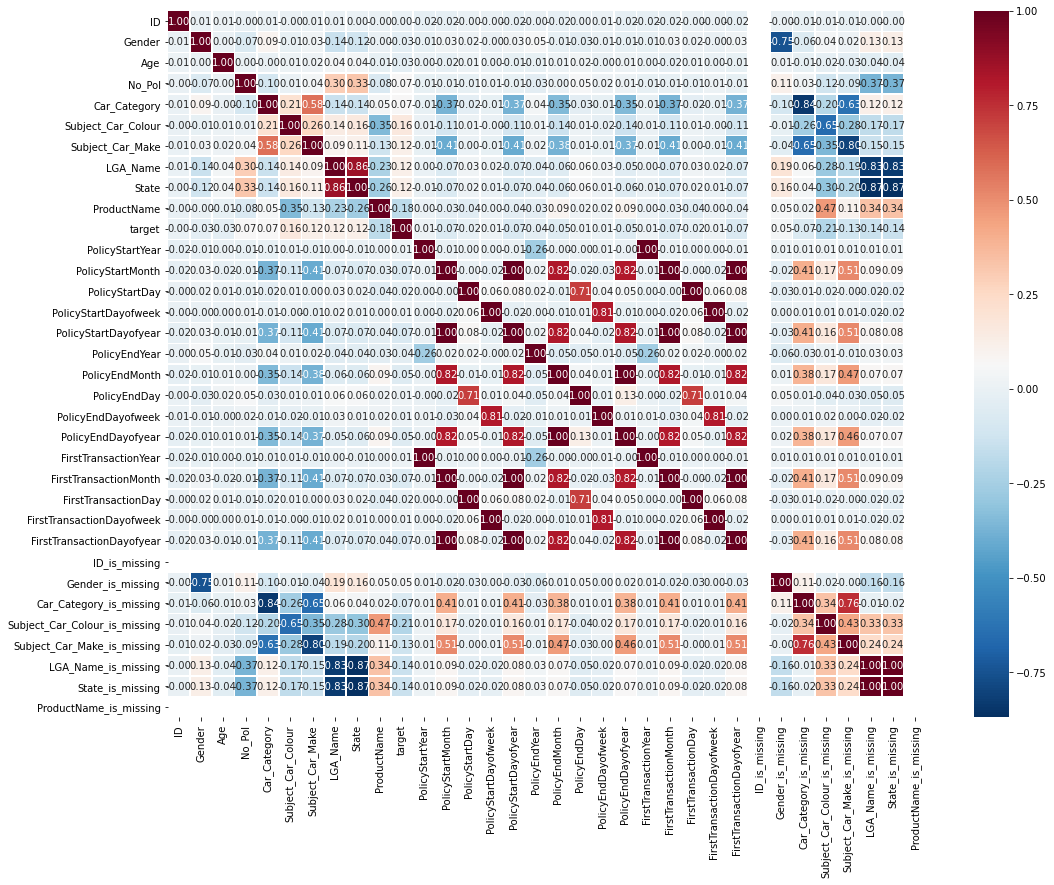

In [90]:
# Find the correlation between the independent variables
corr_matrix = alldata.corr()
plt.figure(figsize=(17, 13))
sns.heatmap(corr_matrix,
            annot=True,
            linewidths=0.5,
            fmt='.2f',
            cmap="RdBu_r");

### Splitting data into train/test sets

According to [zindi](https://zindi.africa/competitions/autoinland-vehicle-insurance-claim-challenge/data) data page, the train and test set are meant to be separate, this makes sense since we will be training the model on the train set and evaluating the model on the test set.

In [91]:
alldata.drop('ID', axis=1, inplace=True)

In [92]:
alldata.head()

,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,...,FirstTransactionDayofweek,FirstTransactionDayofyear,ID_is_missing,Gender_is_missing,Car_Category_is_missing,Subject_Car_Colour_is_missing,Subject_Car_Make_is_missing,LGA_Name_is_missing,State_is_missing,ProductName_is_missing
8010,1,37,0.000000,9,5,28,0,0,4,0.0,...,1,345,False,False,False,False,False,True,True,False
10526,2,37,0.000000,9,5,69,79,24,2,0.0,...,0,84,False,False,False,False,False,False,False,False
10234,2,41,0.185243,9,5,69,124,75,4,0.0,...,6,103,False,False,False,False,False,False,False,False
12066,2,48,0.185243,9,0,8,0,0,4,0.0,...,6,355,False,False,False,True,False,True,True,False
8124,1,44,0.000000,0,0,70,25,75,1,0.0,...,4,217,False,False,True,True,False,False,False,False


In [93]:
train_n = alldata[:ntrain]
test_n = alldata[ntrain:]

In [94]:
len(train_n), len(test_n)

(12079, 1202)

In [95]:
train_n.shape, test_n.shape

((12079, 33), (1202, 33))

In [96]:
train_n.head()

,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,...,FirstTransactionDayofweek,FirstTransactionDayofyear,ID_is_missing,Gender_is_missing,Car_Category_is_missing,Subject_Car_Colour_is_missing,Subject_Car_Make_is_missing,LGA_Name_is_missing,State_is_missing,ProductName_is_missing
8010,1,37,0.000000,9,5,28,0,0,4,0.0,...,1,345,False,False,False,False,False,True,True,False
10526,2,37,0.000000,9,5,69,79,24,2,0.0,...,0,84,False,False,False,False,False,False,False,False
10234,2,41,0.185243,9,5,69,124,75,4,0.0,...,6,103,False,False,False,False,False,False,False,False
12066,2,48,0.185243,9,0,8,0,0,4,0.0,...,6,355,False,False,False,True,False,True,True,False
8124,1,44,0.000000,0,0,70,25,75,1,0.0,...,4,217,False,False,True,True,False,False,False,False


In [97]:
train_n

,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,...,FirstTransactionDayofweek,FirstTransactionDayofyear,ID_is_missing,Gender_is_missing,Car_Category_is_missing,Subject_Car_Colour_is_missing,Subject_Car_Make_is_missing,LGA_Name_is_missing,State_is_missing,ProductName_is_missing
8010,1,37,0.000000,9,5,28,0,0,4,0.0,...,1,345,False,False,False,False,False,True,True,False
10526,2,37,0.000000,9,5,69,79,24,2,0.0,...,0,84,False,False,False,False,False,False,False,False
10234,2,41,0.185243,9,5,69,124,75,4,0.0,...,6,103,False,False,False,False,False,False,False,False
12066,2,48,0.185243,9,0,8,0,0,4,0.0,...,6,355,False,False,False,True,False,True,True,False
8124,1,44,0.000000,0,0,70,25,75,1,0.0,...,4,217,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8539,1,38,0.185243,3,5,69,248,75,3,0.0,...,5,331,False,False,False,False,False,False,False,False
12239,1,29,0.000000,0,0,0,0,0,2,NaN,...,5,331,False,False,True,True,True,True,True,False
2053,2,25,0.000000,0,0,0,0,0,2,0.0,...,5,331,False,False,True,True,True,True,True,False
4544,2,37,0.000000,0,0,0,0,0,2,0.0,...,5,331,False,False,True,True,True,True,True,False


In [98]:
# # Drop any row in the training dataset that has missing values
# train_n = train_n.dropna(axis=0, how='any')
# train_n

In [99]:
# fill the rows with nan values with the majority class
train_n = train_n.fillna({'target': 0.0})
train_n

,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,...,FirstTransactionDayofweek,FirstTransactionDayofyear,ID_is_missing,Gender_is_missing,Car_Category_is_missing,Subject_Car_Colour_is_missing,Subject_Car_Make_is_missing,LGA_Name_is_missing,State_is_missing,ProductName_is_missing
8010,1,37,0.000000,9,5,28,0,0,4,0.0,...,1,345,False,False,False,False,False,True,True,False
10526,2,37,0.000000,9,5,69,79,24,2,0.0,...,0,84,False,False,False,False,False,False,False,False
10234,2,41,0.185243,9,5,69,124,75,4,0.0,...,6,103,False,False,False,False,False,False,False,False
12066,2,48,0.185243,9,0,8,0,0,4,0.0,...,6,355,False,False,False,True,False,True,True,False
8124,1,44,0.000000,0,0,70,25,75,1,0.0,...,4,217,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8539,1,38,0.185243,3,5,69,248,75,3,0.0,...,5,331,False,False,False,False,False,False,False,False
12239,1,29,0.000000,0,0,0,0,0,2,0.0,...,5,331,False,False,True,True,True,True,True,False
2053,2,25,0.000000,0,0,0,0,0,2,0.0,...,5,331,False,False,True,True,True,True,True,False
4544,2,37,0.000000,0,0,0,0,0,2,0.0,...,5,331,False,False,True,True,True,True,True,False


In [100]:
# Change the target column from float to int
train_n.target = train_n.target.astype(int)

In [101]:
# # Drop any row in the test dataset that has missing values
# test_n = test_n.dropna(axis=0, how='any')
# test_n

In [102]:
# fill the rows with nan values with the majority class
test_n = test_n.fillna({'target': 0.0})
test_n

,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,...,FirstTransactionDayofweek,FirstTransactionDayofyear,ID_is_missing,Gender_is_missing,Car_Category_is_missing,Subject_Car_Colour_is_missing,Subject_Car_Make_is_missing,LGA_Name_is_missing,State_is_missing,ProductName_is_missing
7589,2,5,0.000000,0,0,0,259,75,1,0.0,...,5,331,False,False,True,True,True,False,False,False
3571,2,25,0.000000,0,0,0,0,0,2,0.0,...,5,331,False,False,True,True,True,True,True,False
4618,2,32,0.000000,0,0,0,0,0,3,0.0,...,5,331,False,False,True,True,True,True,True,False
4231,2,5,0.000000,0,0,0,259,75,1,0.0,...,5,331,False,False,True,True,True,False,False,False
12777,2,42,0.185243,0,0,0,38,15,2,0.0,...,5,331,False,False,True,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11299,2,37,0.000000,3,0,31,0,0,6,0.0,...,4,365,False,False,False,True,False,True,True,False
10667,1,50,0.000000,0,0,0,0,0,6,0.0,...,4,365,False,False,True,True,True,True,True,False
2886,2,36,0.000000,9,39,40,42,75,2,1.0,...,4,365,False,False,False,False,False,False,False,False
13126,0,51,0.000000,0,12,60,259,75,2,0.0,...,4,365,False,True,True,False,False,False,False,False


In [103]:
# Change the target column from float to int
test_n.target = test_n.target.astype(int)

In [104]:
test_n.head()

,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,...,FirstTransactionDayofweek,FirstTransactionDayofyear,ID_is_missing,Gender_is_missing,Car_Category_is_missing,Subject_Car_Colour_is_missing,Subject_Car_Make_is_missing,LGA_Name_is_missing,State_is_missing,ProductName_is_missing
7589,2,5,0.000000,0,0,0,259,75,1,0,...,5,331,False,False,True,True,True,False,False,False
3571,2,25,0.000000,0,0,0,0,0,2,0,...,5,331,False,False,True,True,True,True,True,False
4618,2,32,0.000000,0,0,0,0,0,3,0,...,5,331,False,False,True,True,True,True,True,False
4231,2,5,0.000000,0,0,0,259,75,1,0,...,5,331,False,False,True,True,True,False,False,False
12777,2,42,0.185243,0,0,0,38,15,2,0,...,5,331,False,False,True,True,True,False,False,False


### Feature Importance

Random forest consists of a number of decision trees. Every node in the decision trees is a condition on a single feature, designed to split the dataset into two so that similar response values end up in the same set. The measure based on which the (locally) optimal condition is chosen is called impurity. When training a tree, it can be computed how much each feature decreases the weighted impurity in a tree. For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure. This is the feature importance measure exposed in sklearn’s Random Forest implementations.

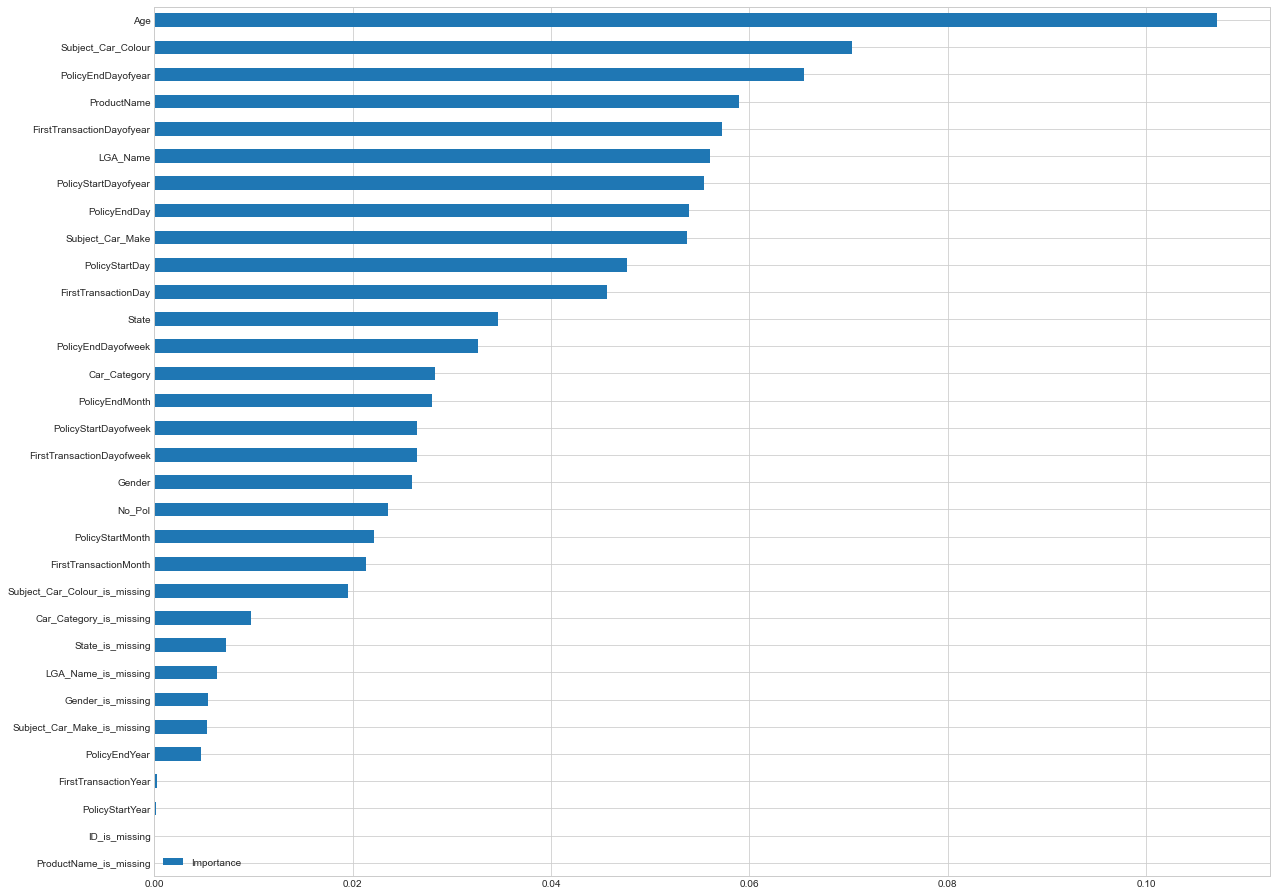

In [105]:
# Using Random Forest to gain an insight on Feature Importance
clf = RandomForestClassifier()
clf.fit(train_n.drop('target', axis=1), train_n['target'])

plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=train_n.drop('target', axis=1).columns, columns=['Importance'])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20, len(importance)/2));

In [106]:
print('Rows containing 0 =', len(train_n[train_n['target']==0]))
print('Rows containing 1 =', len(train_n[train_n['target']==1]))

Rows containing 0 = 10698
Rows containing 1 = 1381


In [107]:
print('Rows containing 0 =', len(test_n[test_n['target']==0]))
print('Rows containing 1 =', len(test_n[test_n['target']==1]))

Rows containing 0 = 1128
Rows containing 1 = 74


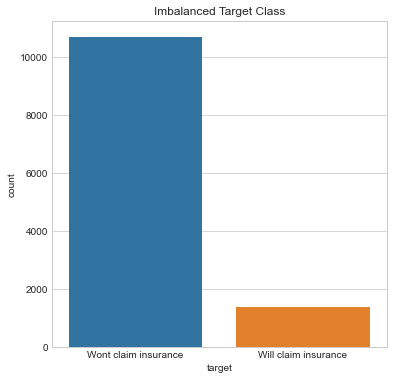

In [108]:
# Visualize the target variable with a bar graph
plt.figure(figsize=(6, 6))
g = sns.countplot('target', data=train_n)
plt.title('Imbalanced Target Class')
g.set_xticklabels(['Wont claim insurance', 'Will claim insurance'])
plt.show();

In [109]:
len(train_n)

12079

### Split the Training Dataset

In [110]:
# Split the training dataset into X and y
X = train_n.drop('target', axis = 1)
y = train_n['target']

In [111]:
X.shape, y.shape

((12079, 32), (12079,))

### Checking for Imbalanced Classification:

In [112]:
y.value_counts()

0    10698
1     1381
Name: target, dtype: int64

<AxesSubplot:>

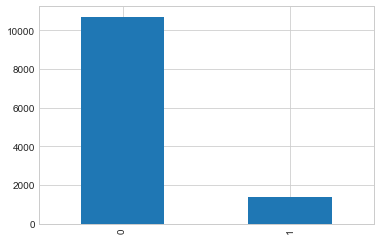

In [113]:
y.value_counts().plot(kind='bar')

### 5. Modelling

### **What is Data Imbalance?**

Data imbalance usually reflects an unequal distribution of classes within a dataset. As with the data set we're working with, The proportion of customers who will claim a car insurance in the first 3 months and customers who will not claim a car insurance in the first 3 months is about 8.13 : 1. If we train our binary classification model without fixing this problem, the model will be completely biased towards the customers who will not claim a car insurance in the first 3 months. Since all of our data is numeric and there are no missing values and we have a highly imbalanced class, we'll attempt to balance the dataset by OverSampling and Undersampling the majority and minority class.

### Applying Oversampling technique for the training dataset(Random Oversampling Minority class)

With my training data created, I’ll upsample the minority class using the SMOTE algorithm (Synthetic Minority Oversampling Technique). At a high level, SMOTE creates synthetic observations of the minority class by:

* Finding the k-nearest-neighbors for minority class observations (finding similar observations)
* Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observation.

After upsampling to a class ratio of 1.0, I should have a balanced dataset. There’s no need (and often it’s not smart) to balance the classes, but it magnifies the issue caused by incorrectly timed oversampling.

In [114]:
from collections import Counter
# # Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
Counter(y_train)

Counter({0: 7473, 1: 982})

In [115]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8455, 32), (3624, 32), (8455,), (3624,))

In [116]:
from imblearn.over_sampling import SMOTE

# summarize class distribution
print("Before Oversampling: ", Counter(y_train))

# over = RandomOverSampler(sampling_strategy='minority')
sm = SMOTE(sampling_strategy='minority', random_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)

Counter(y_sm)
print(f"After Oversampling: {Counter(y_sm)}")

Before Oversampling:  Counter({0: 7473, 1: 982})
After Oversampling: Counter({0: 7473, 1: 7473})


<AxesSubplot:>

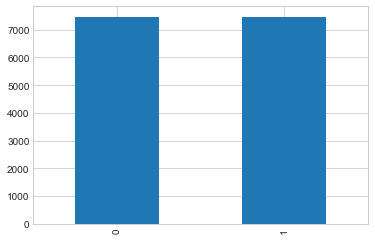

In [117]:
y_sm.value_counts().plot(kind='bar')

In [118]:
X_sm.shape, y_sm.shape

((14946, 32), (14946,))

We're going to be using 6 models to evaluate the sampled dataset:

* Logistic Regression
* RandomForestClassifier
* KNeighborClassifier
* LGBMClassifier
* CatBoostClassifier
* XGBoostClassifier

All of the algorithms in the Scikit-Learn library use the same functions, for training a model, model.fit(X_train, y_train) and for scoring a model model.score(X_test, y_test). score() returns the ratio of correct predictions (1.0 = 100% correct).

In [119]:
# Put models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier(),
          "Lightgbm": LGBMClassifier(),
          "catboost": CatBoostClassifier(),
          "XGBoost": XGBClassifier()}

# Create function to fit and score models
def fit_and_score(models, X_sm, X_test, y_sm, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_over : Oversampled training data
    X_test : testing data
    y_over : labels assosciated with oversampled training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_sm, y_sm)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [120]:
model_scores = fit_and_score(models=models,
                             X_sm=X_sm,
                             X_test=X_test,
                             y_sm=y_sm,
                             y_test=y_test)
model_scores

Learning rate set to 0.032693
0:	learn: 0.6657723	total: 250ms	remaining: 4m 9s
1:	learn: 0.6368848	total: 275ms	remaining: 2m 17s
2:	learn: 0.6106006	total: 308ms	remaining: 1m 42s
3:	learn: 0.5948080	total: 343ms	remaining: 1m 25s
4:	learn: 0.5800436	total: 365ms	remaining: 1m 12s
5:	learn: 0.5612642	total: 386ms	remaining: 1m 4s
6:	learn: 0.5472356	total: 408ms	remaining: 57.9s
7:	learn: 0.5333962	total: 430ms	remaining: 53.4s
8:	learn: 0.5247549	total: 458ms	remaining: 50.4s
9:	learn: 0.5128757	total: 485ms	remaining: 48.1s
10:	learn: 0.5051464	total: 514ms	remaining: 46.2s
11:	learn: 0.4972165	total: 546ms	remaining: 45s
12:	learn: 0.4909572	total: 573ms	remaining: 43.5s
13:	learn: 0.4850032	total: 598ms	remaining: 42.1s
14:	learn: 0.4767971	total: 624ms	remaining: 41s
15:	learn: 0.4737263	total: 651ms	remaining: 40s
16:	learn: 0.4708884	total: 683ms	remaining: 39.5s
17:	learn: 0.4644979	total: 709ms	remaining: 38.7s
18:	learn: 0.4567537	total: 732ms	remaining: 37.8s
19:	learn: 0.

168:	learn: 0.3001521	total: 4.31s	remaining: 21.2s
169:	learn: 0.2999756	total: 4.33s	remaining: 21.1s
170:	learn: 0.2997534	total: 4.35s	remaining: 21.1s
171:	learn: 0.2995291	total: 4.37s	remaining: 21s
172:	learn: 0.2992374	total: 4.39s	remaining: 21s
173:	learn: 0.2984468	total: 4.42s	remaining: 21s
174:	learn: 0.2982925	total: 4.43s	remaining: 20.9s
175:	learn: 0.2981023	total: 4.46s	remaining: 20.9s
176:	learn: 0.2976854	total: 4.48s	remaining: 20.8s
177:	learn: 0.2973761	total: 4.5s	remaining: 20.8s
178:	learn: 0.2973534	total: 4.53s	remaining: 20.8s
179:	learn: 0.2969639	total: 4.55s	remaining: 20.7s
180:	learn: 0.2967892	total: 4.57s	remaining: 20.7s
181:	learn: 0.2964179	total: 4.59s	remaining: 20.6s
182:	learn: 0.2955410	total: 4.62s	remaining: 20.6s
183:	learn: 0.2954078	total: 4.63s	remaining: 20.6s
184:	learn: 0.2950682	total: 4.66s	remaining: 20.5s
185:	learn: 0.2946769	total: 4.68s	remaining: 20.5s
186:	learn: 0.2944753	total: 4.7s	remaining: 20.4s
187:	learn: 0.293648

335:	learn: 0.2537087	total: 8.12s	remaining: 16.1s
336:	learn: 0.2535452	total: 8.15s	remaining: 16s
337:	learn: 0.2535010	total: 8.17s	remaining: 16s
338:	learn: 0.2530716	total: 8.19s	remaining: 16s
339:	learn: 0.2528775	total: 8.21s	remaining: 15.9s
340:	learn: 0.2527976	total: 8.23s	remaining: 15.9s
341:	learn: 0.2525551	total: 8.26s	remaining: 15.9s
342:	learn: 0.2524003	total: 8.28s	remaining: 15.9s
343:	learn: 0.2520874	total: 8.3s	remaining: 15.8s
344:	learn: 0.2519256	total: 8.32s	remaining: 15.8s
345:	learn: 0.2517669	total: 8.35s	remaining: 15.8s
346:	learn: 0.2515471	total: 8.37s	remaining: 15.8s
347:	learn: 0.2511929	total: 8.39s	remaining: 15.7s
348:	learn: 0.2507871	total: 8.42s	remaining: 15.7s
349:	learn: 0.2506370	total: 8.44s	remaining: 15.7s
350:	learn: 0.2505475	total: 8.46s	remaining: 15.7s
351:	learn: 0.2504062	total: 8.48s	remaining: 15.6s
352:	learn: 0.2502931	total: 8.51s	remaining: 15.6s
353:	learn: 0.2501344	total: 8.53s	remaining: 15.6s
354:	learn: 0.24998

499:	learn: 0.2226123	total: 12s	remaining: 12s
500:	learn: 0.2225246	total: 12s	remaining: 12s
501:	learn: 0.2223455	total: 12s	remaining: 11.9s
502:	learn: 0.2221792	total: 12.1s	remaining: 11.9s
503:	learn: 0.2220189	total: 12.1s	remaining: 11.9s
504:	learn: 0.2218432	total: 12.1s	remaining: 11.9s
505:	learn: 0.2217240	total: 12.1s	remaining: 11.8s
506:	learn: 0.2215830	total: 12.2s	remaining: 11.8s
507:	learn: 0.2214613	total: 12.2s	remaining: 11.8s
508:	learn: 0.2213815	total: 12.2s	remaining: 11.8s
509:	learn: 0.2212066	total: 12.2s	remaining: 11.8s
510:	learn: 0.2210912	total: 12.3s	remaining: 11.7s
511:	learn: 0.2209353	total: 12.3s	remaining: 11.7s
512:	learn: 0.2208928	total: 12.3s	remaining: 11.7s
513:	learn: 0.2208599	total: 12.3s	remaining: 11.6s
514:	learn: 0.2206797	total: 12.3s	remaining: 11.6s
515:	learn: 0.2204806	total: 12.4s	remaining: 11.6s
516:	learn: 0.2204368	total: 12.4s	remaining: 11.6s
517:	learn: 0.2203412	total: 12.4s	remaining: 11.5s
518:	learn: 0.2201723	

667:	learn: 0.2016301	total: 15.9s	remaining: 7.91s
668:	learn: 0.2016283	total: 15.9s	remaining: 7.88s
669:	learn: 0.2015589	total: 16s	remaining: 7.86s
670:	learn: 0.2014071	total: 16s	remaining: 7.83s
671:	learn: 0.2013210	total: 16s	remaining: 7.81s
672:	learn: 0.2012387	total: 16s	remaining: 7.79s
673:	learn: 0.2011127	total: 16s	remaining: 7.76s
674:	learn: 0.2011095	total: 16.1s	remaining: 7.74s
675:	learn: 0.2009695	total: 16.1s	remaining: 7.71s
676:	learn: 0.2008501	total: 16.1s	remaining: 7.69s
677:	learn: 0.2007682	total: 16.1s	remaining: 7.66s
678:	learn: 0.2007662	total: 16.2s	remaining: 7.64s
679:	learn: 0.2006798	total: 16.2s	remaining: 7.61s
680:	learn: 0.2005576	total: 16.2s	remaining: 7.59s
681:	learn: 0.2004239	total: 16.2s	remaining: 7.56s
682:	learn: 0.2002776	total: 16.2s	remaining: 7.54s
683:	learn: 0.2000475	total: 16.3s	remaining: 7.51s
684:	learn: 0.1999737	total: 16.3s	remaining: 7.49s
685:	learn: 0.1999159	total: 16.3s	remaining: 7.46s
686:	learn: 0.1999142	

830:	learn: 0.1865261	total: 19.5s	remaining: 3.97s
831:	learn: 0.1863900	total: 19.5s	remaining: 3.95s
832:	learn: 0.1863160	total: 19.6s	remaining: 3.92s
833:	learn: 0.1862085	total: 19.6s	remaining: 3.9s
834:	learn: 0.1861137	total: 19.6s	remaining: 3.88s
835:	learn: 0.1860536	total: 19.6s	remaining: 3.85s
836:	learn: 0.1859682	total: 19.7s	remaining: 3.83s
837:	learn: 0.1858540	total: 19.7s	remaining: 3.8s
838:	learn: 0.1858088	total: 19.7s	remaining: 3.78s
839:	learn: 0.1857002	total: 19.7s	remaining: 3.76s
840:	learn: 0.1856449	total: 19.8s	remaining: 3.74s
841:	learn: 0.1855599	total: 19.8s	remaining: 3.71s
842:	learn: 0.1854323	total: 19.8s	remaining: 3.69s
843:	learn: 0.1853740	total: 19.9s	remaining: 3.67s
844:	learn: 0.1852353	total: 19.9s	remaining: 3.65s
845:	learn: 0.1851411	total: 19.9s	remaining: 3.63s
846:	learn: 0.1850802	total: 20s	remaining: 3.6s
847:	learn: 0.1850199	total: 20s	remaining: 3.58s
848:	learn: 0.1849105	total: 20s	remaining: 3.56s
849:	learn: 0.1848609

991:	learn: 0.1725936	total: 23.4s	remaining: 188ms
992:	learn: 0.1724657	total: 23.4s	remaining: 165ms
993:	learn: 0.1723467	total: 23.4s	remaining: 141ms
994:	learn: 0.1722488	total: 23.5s	remaining: 118ms
995:	learn: 0.1722134	total: 23.5s	remaining: 94.4ms
996:	learn: 0.1720795	total: 23.5s	remaining: 70.8ms
997:	learn: 0.1719889	total: 23.6s	remaining: 47.2ms
998:	learn: 0.1719094	total: 23.6s	remaining: 23.6ms
999:	learn: 0.1718458	total: 23.6s	remaining: 0us
[09:53:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'KNN': 0.7036423841059603,
 'Logistic Regression': 0.6158940397350994,
 'Random Forest': 0.8363686534216336,
 'Lightgbm': 0.8396799116997793,
 'catboost': 0.8449227373068433,
 'XGBoost': 0.8421633554083885}

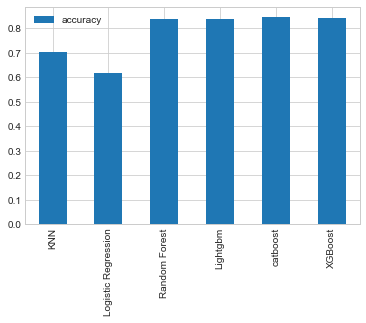

In [121]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

Since Catboost and Lightgbm performed better than the other models, we'll use these model to fit and score the oversampled training and test dataset.

### LightGBM Model

In [122]:
clf_lgb = LGBMClassifier(n_estimators=200, random_state=42)

# Fit the lgb classifier to the training data
clf_lgb.fit(X_sm, y_sm);

In [123]:
# Evaluate the lightgbm model
clf_lgb.score(X_test, y_test)

0.8413355408388521

### Catboost Model

In [174]:
clf_cat = CatBoostClassifier(n_estimators=700, random_state=42)

# Fit the catboost classifier to the model
clf_cat.fit(X_sm, y_sm)

Learning rate set to 0.045342
0:	learn: 0.6485439	total: 25.4ms	remaining: 17.8s
1:	learn: 0.6212330	total: 41.2ms	remaining: 14.4s
2:	learn: 0.5905848	total: 55.4ms	remaining: 12.9s
3:	learn: 0.5685132	total: 70ms	remaining: 12.2s
4:	learn: 0.5484381	total: 85.2ms	remaining: 11.8s
5:	learn: 0.5303076	total: 100ms	remaining: 11.6s
6:	learn: 0.5165321	total: 115ms	remaining: 11.4s
7:	learn: 0.5054638	total: 130ms	remaining: 11.2s
8:	learn: 0.5003941	total: 145ms	remaining: 11.1s
9:	learn: 0.4891018	total: 159ms	remaining: 11s
10:	learn: 0.4773944	total: 173ms	remaining: 10.9s
11:	learn: 0.4698075	total: 188ms	remaining: 10.8s
12:	learn: 0.4661270	total: 207ms	remaining: 11s
13:	learn: 0.4630534	total: 225ms	remaining: 11s
14:	learn: 0.4541347	total: 244ms	remaining: 11.1s
15:	learn: 0.4490224	total: 260ms	remaining: 11.1s
16:	learn: 0.4424718	total: 275ms	remaining: 11s
17:	learn: 0.4344668	total: 290ms	remaining: 11s
18:	learn: 0.4294270	total: 305ms	remaining: 10.9s
19:	learn: 0.42573

165:	learn: 0.2784432	total: 2.83s	remaining: 9.12s
166:	learn: 0.2779858	total: 2.85s	remaining: 9.1s
167:	learn: 0.2776320	total: 2.87s	remaining: 9.09s
168:	learn: 0.2772374	total: 2.89s	remaining: 9.07s
169:	learn: 0.2770079	total: 2.9s	remaining: 9.05s
170:	learn: 0.2767926	total: 2.92s	remaining: 9.02s
171:	learn: 0.2765279	total: 2.93s	remaining: 9.01s
172:	learn: 0.2761579	total: 2.95s	remaining: 8.99s
173:	learn: 0.2759803	total: 2.97s	remaining: 8.98s
174:	learn: 0.2757755	total: 2.98s	remaining: 8.95s
175:	learn: 0.2754724	total: 3s	remaining: 8.93s
176:	learn: 0.2747246	total: 3.02s	remaining: 8.92s
177:	learn: 0.2741977	total: 3.04s	remaining: 8.91s
178:	learn: 0.2740054	total: 3.06s	remaining: 8.9s
179:	learn: 0.2737259	total: 3.08s	remaining: 8.9s
180:	learn: 0.2734384	total: 3.1s	remaining: 8.88s
181:	learn: 0.2731388	total: 3.12s	remaining: 8.88s
182:	learn: 0.2728716	total: 3.14s	remaining: 8.87s
183:	learn: 0.2726558	total: 3.15s	remaining: 8.85s
184:	learn: 0.271876

334:	learn: 0.2288741	total: 5.57s	remaining: 6.07s
335:	learn: 0.2285555	total: 5.59s	remaining: 6.06s
336:	learn: 0.2283226	total: 5.61s	remaining: 6.05s
337:	learn: 0.2281147	total: 5.63s	remaining: 6.04s
338:	learn: 0.2278239	total: 5.66s	remaining: 6.02s
339:	learn: 0.2277653	total: 5.67s	remaining: 6s
340:	learn: 0.2275520	total: 5.69s	remaining: 5.99s
341:	learn: 0.2272393	total: 5.7s	remaining: 5.97s
342:	learn: 0.2269979	total: 5.72s	remaining: 5.95s
343:	learn: 0.2268502	total: 5.73s	remaining: 5.93s
344:	learn: 0.2266371	total: 5.75s	remaining: 5.91s
345:	learn: 0.2263828	total: 5.76s	remaining: 5.89s
346:	learn: 0.2261387	total: 5.78s	remaining: 5.88s
347:	learn: 0.2258996	total: 5.8s	remaining: 5.87s
348:	learn: 0.2255417	total: 5.82s	remaining: 5.85s
349:	learn: 0.2254303	total: 5.83s	remaining: 5.83s
350:	learn: 0.2250396	total: 5.85s	remaining: 5.81s
351:	learn: 0.2248972	total: 5.86s	remaining: 5.79s
352:	learn: 0.2246181	total: 5.88s	remaining: 5.78s
353:	learn: 0.224

500:	learn: 0.2001915	total: 8.21s	remaining: 3.26s
501:	learn: 0.2000786	total: 8.23s	remaining: 3.25s
502:	learn: 0.2000677	total: 8.25s	remaining: 3.23s
503:	learn: 0.1999434	total: 8.26s	remaining: 3.21s
504:	learn: 0.1997045	total: 8.28s	remaining: 3.2s
505:	learn: 0.1994913	total: 8.29s	remaining: 3.18s
506:	learn: 0.1994729	total: 8.31s	remaining: 3.16s
507:	learn: 0.1992937	total: 8.32s	remaining: 3.15s
508:	learn: 0.1991235	total: 8.34s	remaining: 3.13s
509:	learn: 0.1989586	total: 8.35s	remaining: 3.11s
510:	learn: 0.1987647	total: 8.37s	remaining: 3.1s
511:	learn: 0.1985451	total: 8.38s	remaining: 3.08s
512:	learn: 0.1984096	total: 8.4s	remaining: 3.06s
513:	learn: 0.1982228	total: 8.42s	remaining: 3.05s
514:	learn: 0.1980322	total: 8.44s	remaining: 3.03s
515:	learn: 0.1979153	total: 8.45s	remaining: 3.01s
516:	learn: 0.1977685	total: 8.47s	remaining: 3s
517:	learn: 0.1976252	total: 8.48s	remaining: 2.98s
518:	learn: 0.1973964	total: 8.5s	remaining: 2.96s
519:	learn: 0.19725

661:	learn: 0.1786482	total: 10.8s	remaining: 622ms
662:	learn: 0.1785532	total: 10.8s	remaining: 605ms
663:	learn: 0.1784452	total: 10.9s	remaining: 589ms
664:	learn: 0.1782709	total: 10.9s	remaining: 573ms
665:	learn: 0.1781179	total: 10.9s	remaining: 556ms
666:	learn: 0.1780191	total: 10.9s	remaining: 540ms
667:	learn: 0.1778765	total: 10.9s	remaining: 524ms
668:	learn: 0.1777554	total: 11s	remaining: 507ms
669:	learn: 0.1775953	total: 11s	remaining: 491ms
670:	learn: 0.1773977	total: 11s	remaining: 475ms
671:	learn: 0.1772234	total: 11s	remaining: 459ms
672:	learn: 0.1771094	total: 11s	remaining: 442ms
673:	learn: 0.1769284	total: 11s	remaining: 426ms
674:	learn: 0.1768326	total: 11.1s	remaining: 410ms
675:	learn: 0.1767192	total: 11.1s	remaining: 393ms
676:	learn: 0.1766289	total: 11.1s	remaining: 377ms
677:	learn: 0.1765246	total: 11.1s	remaining: 361ms
678:	learn: 0.1764532	total: 11.1s	remaining: 344ms
679:	learn: 0.1763437	total: 11.2s	remaining: 328ms
680:	learn: 0.1762110	to

In [175]:
# Evaluate the catboost model
clf_cat.score(X_test, y_test)

0.8457505518763797

Since Catboost performed better than Lightgbm, we'll use the model to make predictions.

### Evaluating the classification model, beyond the default accuracy

Now we've got a tuned model.

We want:

* ROC curve and AUC score - plot_roc_curve()
* Confusion matrix - confusion_matrix()
* Classification report - classification_report()
* Precision - precision_score()
* Recall - recall_score()
* F1-score - f1_score()

In [176]:
# Make predictions on test data with catboost
y_pred = clf_cat.predict(X_test)
y_pred[:20]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

In [177]:
len(X_test)

3624

In [178]:
# Comparing y_test with the predicted result
y_test[:20]

4979     0
2105     0
6434     0
8676     1
288      0
10036    0
11647    0
3510     1
3542     0
6772     0
1557     0
6131     1
13137    0
7705     0
12400    0
12373    0
12036    0
1852     0
4224     0
7563     1
Name: target, dtype: int32

### ROC Curve and AUC Scores for Catboost

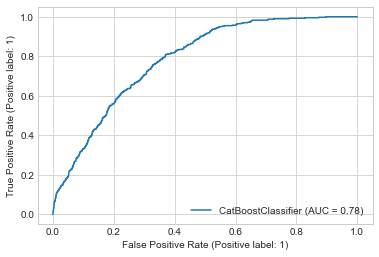

In [179]:
# Plot ROC curve
plot_roc_curve(clf_cat, X_test, y_test);

### Confusion Matrix for Catboost Model

[[2944  281]
 [ 278  121]]


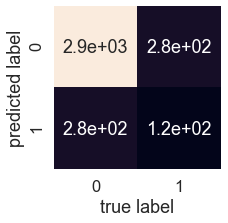

In [180]:
# Import Seaborn
import seaborn as sns
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                     annot=True, 
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, y_pred)
print(confusion_matrix(y_test,y_pred))

You can see the model gets confused (predicts the wrong label) across both classes. In essence, there are 281 occasaions where the model predicted 0 when it should've been 1 (false negative) and 278 occasions where the model predicted 1 instead of 0 (false positive).

### Classification report

In [181]:
target_names = ['Class 0', 'Class 1']
print('********************Classification Report on the Training Dataset*********************')
print(classification_report(y_test, y_pred, target_names=target_names))

********************Classification Report on the Training Dataset*********************
              precision    recall  f1-score   support

     Class 0       0.91      0.91      0.91      3225
     Class 1       0.30      0.30      0.30       399

    accuracy                           0.85      3624
   macro avg       0.61      0.61      0.61      3624
weighted avg       0.85      0.85      0.85      3624



In [182]:
# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

F1 score on the X_test is: 0.3021223470661673


### Train on full dataset

In [183]:
test_n['target'].value_counts()

0    1128
1      74
Name: target, dtype: int64

<AxesSubplot:>

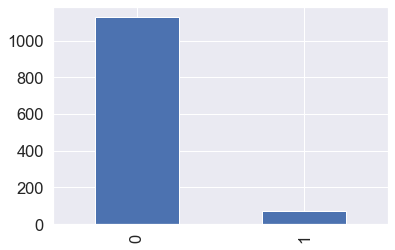

In [184]:
test_n['target'].value_counts().plot(kind='bar')

In [185]:
prediction = clf_cat.predict(test_n)
prediction[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [186]:
set(test.ID==ss.ID)

{True}

In [187]:
ss.head()

,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0


In [188]:
sub_file = ss.copy()

In [189]:
sub_file.target = prediction

In [190]:
sub_file.head()

,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0


In [191]:
sub_file.to_csv('base_model_pred_model.csv', index=False)